# Kaggle Competition: Description Analysis

<img src="https://octodex.github.com/images/yaktocat.png" alt="Kit" title="Cat" width="350" height="200" />
*(image from octodex github)*

*Description Analysis before modeling to predict at which speed a pet is adopted.*

## Python Packages

In [8]:
# Import Packages

#Dataframe packages
import zipfile
import json
import objectpath
import pandas as pd
import numpy as np
import os
from PIL import Image
import requests
from io import BytesIO
import cv2
import numpy as np


#Plot packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator



## Datasets

The data is provided by [Petfinder.my](https://www.kaggle.com/c/petfinder-adoption-prediction) , a platform dedicated for pets adoption. 
The objective is to predict at which speed a pet is adopted. 

There are 6 different sources of data + Images + Metadata Images and Sentiment Data 
-   Train.csv
-   Test.csv
-   breed_labels.csv
-   color_labels.csv
-   state_labels.csv
-   Images (zip file) from cats and dogs that are adopted
-   Metadata Images (zip file) information about the Image using Google Vision API
-   Sentiment Data is based on the Descriptions using Google's Natural Language API. 


<img src="https://i.imgur.com/i10SHmQ.jpg" alt="K" title="Datasets" width="700" height="400" />

### Sentiment Data

In [9]:
# Define Empty lists
d = None  
data = None  
score=[]
magnitude=[]
petid=[]

# Read Zip File and Export a Dataset with the Score and the ID
with zipfile.ZipFile(r'C:\Users\alorenzodebrionne\Documents\Kaggle\Pet.my\train_sentiment.zip', "r") as z:
   for filename in z.namelist():  
      with z.open(filename) as f:  
         data = f.read()  
         d = json.loads(data.decode("utf-8"))
         json_tree = objectpath.Tree(d['documentSentiment'])
         result_tuple = tuple(json_tree.execute('$..score'))
         result_tuple2=tuple(json_tree.execute('$..magnitude'))
         score.append(result_tuple)
         magnitude.append(result_tuple2)
         
      petid.append(filename.replace('.json',''))

# Output with sentiment data for each pet
# Output with sentiment data for each pet
sentimental_analysis = pd.concat([ pd.DataFrame(petid, columns =['PetID']) ,pd.DataFrame(score, columns =['sentiment_document_score']),
                                                pd.DataFrame(magnitude, columns =['sentiment_document_magnitude'])],axis =1)

### Image Metadata

In this step we will export the description and the topicality of each image. For more information on [Google API Vision](https://cloud.google.com/vision/)

<img src="https://i.imgur.com/7Hc9gXQ.png" alt="Dogplant" title="Dogplant" width="500" height="600" />
As example in this image the dog is not on the foreground. The Google API doesn't detect the dog.


In [10]:
# Define Empty lists
d = None  
data = None  
description=[]
topicality=[]
imageid=[]


# Read Zip File and Export a Dataset with the Topicality and Description for each Image
with zipfile.ZipFile(r'C:\Users\alorenzodebrionne\Documents\Kaggle\Pet.My\train_metadata.zip', "r") as z:
   for filename in z.namelist():  
       #Open the Zip File
      with z.open(filename) as f:  
          #Read the json File
          data = f.read()
          d = json.loads(data.decode("utf-8"))
          #Check if the file contains the parent label Annotations and export description and topicality
          if 'labelAnnotations' in d:
             json_tree = objectpath.Tree(d['labelAnnotations'])
             image_metadata1 = list(tuple(json_tree.execute('$..description')))
             image_metadata2 =  list(tuple(json_tree.execute('$..topicality')))

             #Create a list of all descriptions and topicality
             description.append(image_metadata1)
             topicality.append(image_metadata2)
         
             #Create a list with all image id name
             imageid.append(filename.replace('.json',''))


# Prepare the output by renaming all variables
description=pd.DataFrame(description)
topicality=pd.DataFrame(topicality)

new_names = [(i,'metadata_description_'+str(i)) for i in description.iloc[:, 0:].columns.values]
description.rename(columns = dict(new_names), inplace=True)

new_names = [(i,'metadata_topicality_'+str(i)) for i in topicality.iloc[:, 0:].columns.values]
topicality.rename(columns = dict(new_names), inplace=True)

# Output with sentiment data for each pet
image_metadata = pd.concat([ pd.DataFrame(imageid, columns =['ImageId']) ,topicality,description],axis =1)

# create the PetId variable
image_metadata['PetID'] = image_metadata['ImageId'].str.split('-').str[0]


##############
# TOPICALITY #
##############

image_metadata['metadata_topicality_mean'] = image_metadata.iloc[:,1:10].mean(axis=1)
image_metadata['metadata_topicality_mean']  = image_metadata.groupby(['PetID'])['metadata_topicality_mean'].transform('mean') 

image_metadata['metadata_topicality_max'] = image_metadata.iloc[:,1:10].max(axis=1)
image_metadata['metadata_topicality_max'] = image_metadata.groupby(['PetID'])['metadata_topicality_max'].transform(max)

image_metadata['metadata_topicality_min'] = image_metadata.iloc[:,1:10].min(axis=1)
image_metadata['metadata_topicality_min'] = image_metadata.groupby(['PetID'])['metadata_topicality_min'].transform(min)


image_metadata['metadata_topicality_0_mean']  = image_metadata.groupby(['PetID'])['metadata_topicality_0'].transform('mean')
image_metadata['metadata_topicality_0_max'] = image_metadata.groupby(['PetID'])['metadata_topicality_0'].transform(max)
image_metadata['metadata_topicality_0_min'] = image_metadata.groupby(['PetID'])['metadata_topicality_0'].transform(min)


###############
# DESCRIPTION #
###############

# Create Features from the Images
image_metadata['L_metadata_0_cat']=image_metadata['metadata_description_0'].str.contains("cat").astype(int)
image_metadata['L_metadata_0_dog'] =image_metadata['metadata_description_0'].str.contains("dog").astype(int)

image_metadata['L_metadata_any_cat']=image_metadata.apply(lambda row: row.astype(str).str.contains('cat').any(), axis=1)
image_metadata['L_metadata_any_dog']=image_metadata.apply(lambda row: row.astype(str).str.contains('dog').any(), axis=1)

image_metadata['L_metadata_0_cat_sum'] = image_metadata.groupby(image_metadata['PetID'])['L_metadata_0_cat'].transform('sum')
image_metadata['L_metadata_0_dog_sum'] = image_metadata.groupby(image_metadata['PetID'])['L_metadata_0_dog'].transform('sum')

image_metadata['L_metadata_any_cat_sum'] = image_metadata.groupby(image_metadata['PetID'])['L_metadata_any_cat'].transform('sum')
image_metadata['L_metadata_any_dog_sum'] = image_metadata.groupby(image_metadata['PetID'])['L_metadata_any_dog'].transform('sum')

image_metadata = image_metadata[['PetID','metadata_topicality_max','metadata_topicality_mean','metadata_topicality_min','metadata_topicality_0_mean','metadata_topicality_0_max','metadata_topicality_0_min','L_metadata_0_cat_sum','L_metadata_0_dog_sum','L_metadata_any_cat_sum','L_metadata_any_dog_sum']]
image_metadata=image_metadata.drop_duplicates('PetID')


In [12]:
d = None  
data = None  

color_score_mean=[]
color_score_min=[]
color_score_max=[]

color_pixelfrac_mean=[]
color_pixelfrac_min=[]
color_pixelfrac_max=[]

imageid=[]

# Read Zip File and Export a Dataset with the Score and the ID
with zipfile.ZipFile(r'C:\Users\alorenzodebrionne\Documents\Kaggle\Pet.My\train_metadata.zip', "r") as z:
   for filename in z.namelist():  
      with z.open(filename) as f:  
          data = f.read()
          d = json.loads(data.decode("utf-8"))
          file_keys = list(d.keys())
          if  'imagePropertiesAnnotation' in file_keys:
              file_colors = d['imagePropertiesAnnotation']['dominantColors']['colors']
              file_crops = d['cropHintsAnnotation']['cropHints']
              
              file_color_score_mean = np.asarray([x['score'] for x in file_colors]).mean()
              file_color_pixelfrac_mean = np.asarray([x['pixelFraction'] for x in file_colors]).mean()
              
              file_color_score_min = np.asarray([x['score'] for x in file_colors]).min()
              file_color_pixelfrac_min = np.asarray([x['pixelFraction'] for x in file_colors]).min()

              
              file_color_score_max = np.asarray([x['score'] for x in file_colors]).max()
              file_color_pixelfrac_max = np.asarray([x['pixelFraction'] for x in file_colors]).max()
              
              
          #Create a list with all image id name
          imageid.append(filename.replace('.json',''))
          
          color_score_mean.append(file_color_score_mean)
          color_score_min.append(file_color_score_min)
          color_score_max.append(file_color_score_max)
          
          
          color_pixelfrac_mean.append(file_color_pixelfrac_mean)
          color_pixelfrac_min.append(file_color_pixelfrac_min)
          color_pixelfrac_max.append(file_color_pixelfrac_max)

image_properties = pd.concat([pd.DataFrame({'ImageId':imageid}),pd.DataFrame({'metadata_color_pixelfrac_mean':color_pixelfrac_mean}), pd.DataFrame({'metadata_color_pixelfrac_min':color_pixelfrac_min}),pd.DataFrame({'metadata_color_pixelfrac_max':color_pixelfrac_max}),pd.DataFrame({'metadata_color_score_mean':color_score_mean}),pd.DataFrame({'metadata_color_score_min':color_score_min}),pd.DataFrame({'metadata_color_score_max':color_score_max})],axis=1)

# create the PetId variable
image_properties['PetID'] = image_properties['ImageId'].str.split('-').str[0]


##############
# COLOR INFO #
##############
image_properties['metadata_color_pixelfrac_mean']  = image_properties.groupby(['PetID'])['metadata_color_pixelfrac_mean'].transform('mean') 
image_properties['metadata_color_pixelfrac_min']  = image_properties.groupby(['PetID'])['metadata_color_pixelfrac_min'].transform(min) 
image_properties['metadata_color_pixelfrac_max']  = image_properties.groupby(['PetID'])['metadata_color_pixelfrac_max'].transform(max) 

image_properties['metadata_color_score_mean']  = image_properties.groupby(['PetID'])['metadata_color_score_mean'].transform('mean') 
image_properties['metadata_color_score_min']  = image_properties.groupby(['PetID'])['metadata_color_score_min'].transform(min) 
image_properties['metadata_color_score_max']  = image_properties.groupby(['PetID'])['metadata_color_score_max'].transform(max) 



### Automatic Image Quality 

Image quality assessment aims to quantitatively represent the human perception of quality. To assign quality images we will add : pixels and  blur score using the variance of Laplacian.  
The following variables are created:
-  Pixel of all images for a pet
-  Pixel average for all pictures for a Pet
-  Blur of all images for a pet
-  Blur average for all pictures for a Pet

<img src="https://i.imgur.com/KjM8TdF.jpg" alt="CatBlur" title="CatBlur" width="200" height="300" />
Example of a blur image.

In [ ]:
def variance_of_laplacian(data):
    image = cv2.imdecode(np.frombuffer(data, np.uint8), 1)      
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(gray, cv2.CV_64F).var() 

blur=[]
image_pixel=[]
imageid =[]

#Read the Zip File    
with zipfile.ZipFile(r'C:\Users\alorenzodebrionne\Documents\Kaggle\Pet.My\train_images.zip',"r") as zfile:
      for filename in zfile.namelist():
              
              #Blur 
              data = zfile.read(filename)
              # Pixels
              with Image.open( BytesIO(data)) as pixel:
                  width, height = pixel.size
              
              pixel = width*height
              
              #image pixel size for each image
              image_pixel.append(pixel)
              #blur for each image
              blur.append(variance_of_laplacian(data))
              #image id
              imageid.append(filename.replace('.jpg',''))
          
          
# Join Pixel, Blur and Image ID
image_quality = pd.concat([ pd.DataFrame(imageid, columns =['ImageId']) ,pd.DataFrame(blur, columns =['blur']),
                                        pd.DataFrame(image_pixel,columns=['pixel'])],axis =1)

# create the PetId variable
image_quality['PetID'] = image_quality['ImageId'].str.split('-').str[0]

#Mean of the Mean
image_quality['pixel_mean'] = image_quality.groupby(['PetID'])['pixel'].transform('mean')
image_quality['blur_mean'] = image_quality.groupby(['PetID'])['blur'].transform('mean') 

image_quality['pixel_min'] = image_quality.groupby(['PetID'])['pixel'].transform('min') 
image_quality['blur_min'] = image_quality.groupby(['PetID'])['blur'].transform('min')

image_quality['pixel_max'] = image_quality.groupby(['PetID'])['pixel'].transform('max') 
image_quality['blur_max'] = image_quality.groupby(['PetID'])['blur'].transform('max')

image_quality['pixel_sum'] = image_quality.groupby(['PetID'])['pixel'].transform('sum')
image_quality['blur_sum'] = image_quality.groupby(['PetID'])['blur'].transform('sum')


image_quality = image_quality.drop(['blur','pixel'], 1)
image_quality=image_quality.drop_duplicates('PetID')

### Adoption Data 

In [ ]:
#Load Data
train =pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/train.csv')
#test = pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/test.csv')
breed =pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/breed_labels.csv',usecols=["BreedID", "BreedName"]) #A pet could have multiple breed
color =pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/color_labels.csv') #A pet could have multiple colors
state =pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/state_labels.csv')

# Add information about color, breed, state and sentiment data
train = (pd.merge(train, breed.rename(columns={"BreedName": "BreedName1"}),  how='left', left_on=['Breed1'], right_on = ['BreedID']).drop('BreedID', axis=1))
train = (pd.merge(train, breed.rename(columns={"BreedName": "BreedName2"}),  how='left', left_on=['Breed2'], right_on = ['BreedID']).drop('BreedID', axis=1))

train = (pd.merge(train, color.rename(columns={"ColorName": "ColorName1"}),  how='left', left_on=['Color1'], right_on = ['ColorID']).drop('ColorID', axis=1))
train = (pd.merge(train, color.rename(columns={"ColorName": "ColorName2"}),  how='left', left_on=['Color2'], right_on = ['ColorID']).drop('ColorID', axis=1))
train = (pd.merge(train, color.rename(columns={"ColorName": "ColorName3"}),  how='left', left_on=['Color3'], right_on = ['ColorID']).drop('ColorID', axis=1))

train = (pd.merge(train, state,  how='left', left_on=['State'], right_on = ['StateID']).drop('StateID', axis=1))

train = (pd.merge(train, sentimental_analysis,  how='left', left_on=['PetID'], right_on = ['PetID']))

# Add information about Metadata Images
train = (pd.merge(train, image_metadata,  how='left', left_on=['PetID'], right_on = ['PetID']))
# Add information about Metadata Images
train = (pd.merge(train, image_properties,  how='left', left_on=['PetID'], right_on = ['PetID']))


# Add information about quality Images
train = (pd.merge(train, image_quality,  how='left', left_on=['PetID'], right_on = ['PetID']))


### Features Engineering

In [ ]:
# Color (Create a Flag pet has 1 color, 2 colors, 3 colors)
train['L_Color1'] = (pd.isnull(train['ColorName3']) & pd.isnull(train['ColorName2']) & pd.notnull(train['ColorName1'])).astype(int)
train['L_Color2'] = (pd.isnull(train['ColorName3']) & pd.notnull(train['ColorName2']) & pd.notnull(train['ColorName1'])).astype(int)
train['L_Color3'] = (pd.notnull(train['ColorName3']) & pd.notnull(train['ColorName2']) & pd.notnull(train['ColorName1'])).astype(int)

# Breed (create a flag if the pet has 1 breed or 2)
train['L_Breed1'] = (pd.isnull(train['BreedName2']) & pd.notnull(train['BreedName1'])).astype(int)
train['L_Breed2'] = (pd.notnull(train['BreedName2']) & pd.notnull(train['BreedName1'])).astype(int)

#Name (create a flag if the name is missing, with less than two letters)
train['L_Name_missing'] =  (pd.isnull(train['Name'])).astype(int)
train['Name_Length']=train['Name'].str.len() 

#Description 
train['Description_Length']=train['Description'].str.len() 

# Fee Amount
train['L_Fee_Free'] =  (train['Fee']==0).astype(int)

#Add the Number of Pets per Rescuer 
pets_total = train.groupby(['RescuerID']).size().reset_index(name='N_pets_total')
train= pd.merge(train, pets_total, left_on='RescuerID', right_on='RescuerID', how='inner')
train.count()

# No photo
train['L_NoPhoto'] =  (train['PhotoAmt']==0).astype(int)

#No Video
train['L_NoVideo'] =  (train['VideoAmt']==0).astype(int)

#Log Age 
train['Log_Age']= np.log(train.Age+1) 

#Negative Score 
train['L_scoreneg'] =  (train['sentiment_document_score']<0).astype(int)

#Quantity Amount >5
train.loc[train['Quantity'] > 5, 'Quantity'] = 5

## Adoption Data Exploration

In [ ]:
train.head(100)

In [27]:
# As we see we will need to deal with missing values. 
# Variables with more than 50% of missing values will not be included in the model
train.count()

Type                         14993
Name                         13736
Age                          14993
Breed1                       14993
Breed2                       14993
Gender                       14993
Color1                       14993
Color2                       14993
Color3                       14993
MaturitySize                 14993
FurLength                    14993
Vaccinated                   14993
Dewormed                     14993
Sterilized                   14993
Health                       14993
Quantity                     14993
Fee                          14993
State                        14993
RescuerID                    14993
VideoAmt                     14993
Description                  14981
PetID                        14993
PhotoAmt                     14993
AdoptionSpeed                14993
BreedName1                   14988
BreedName2                    4231
ColorName1                   14993
ColorName2                   10522
ColorName3          

### Target Analysis


 -   0 - Pet was adopted on the same day as it was listed.
 -   1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
 -   2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
 -   3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
 -   4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).


In [8]:
total = float(len(train)) # one person per row 
ax =sns.countplot(x="AdoptionSpeed", data=train,palette="Set3")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height,
            '{:1.2f}'.format(height/total),
            ha="center") 


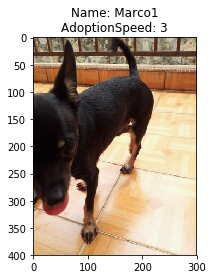

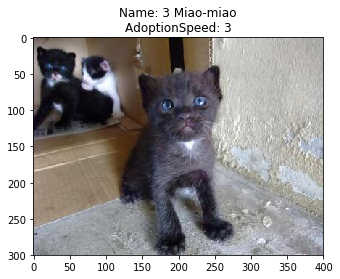

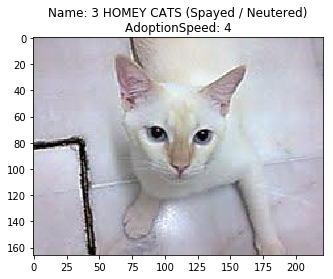

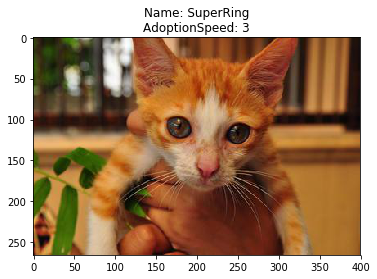

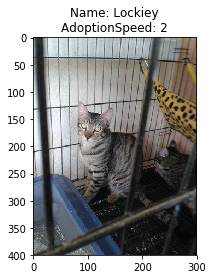

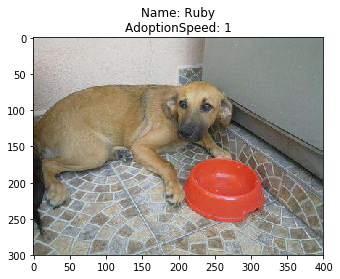

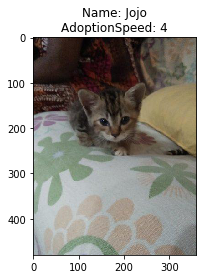

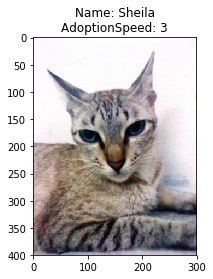

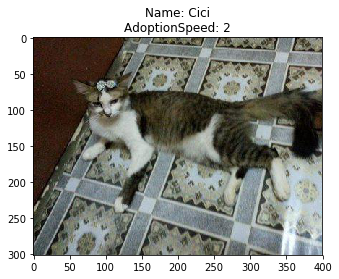

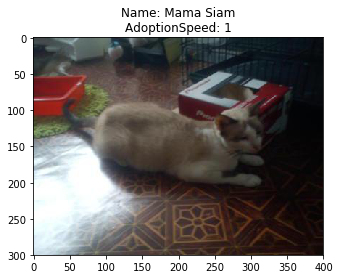

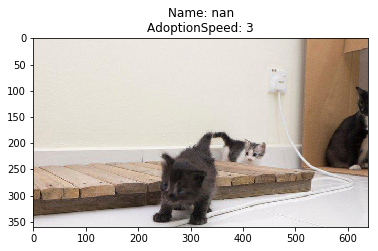

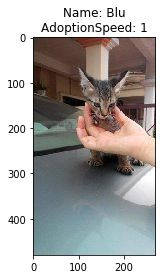

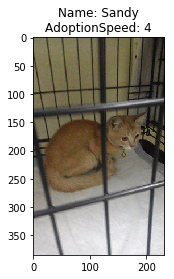

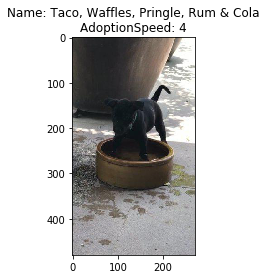

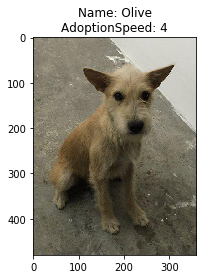

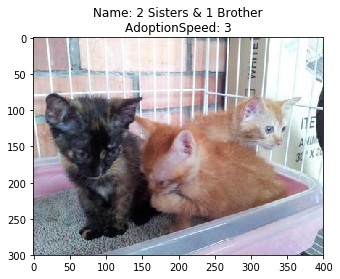

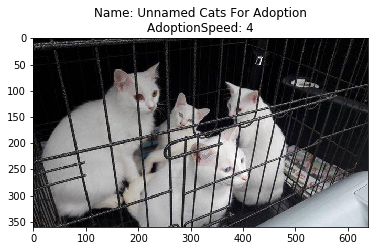

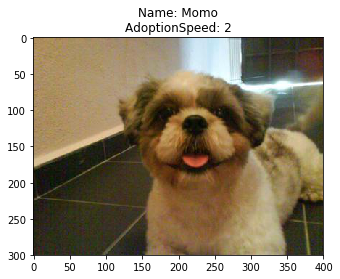

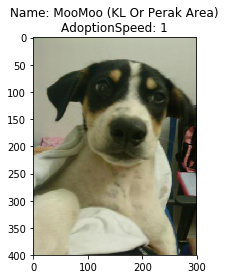

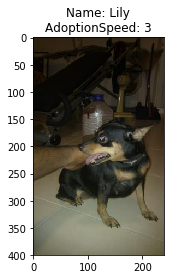

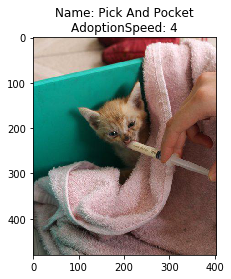

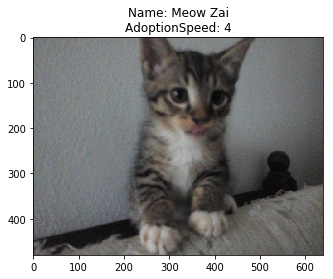

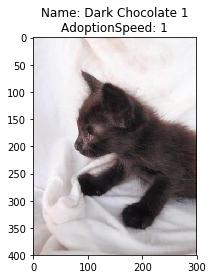

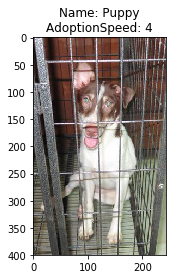

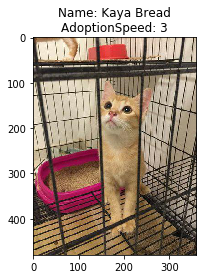

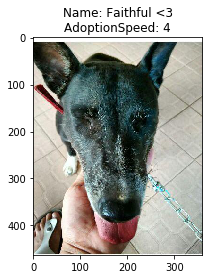

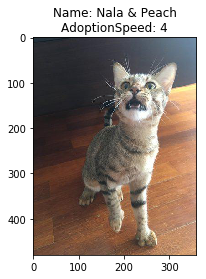

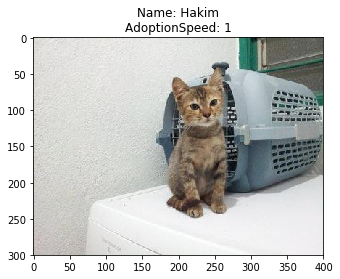

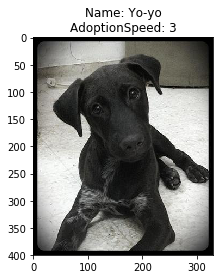

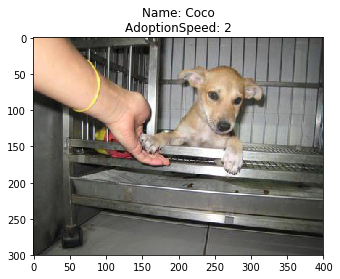

In [58]:
with zipfile.ZipFile(r'C:\Users\alorenzodebrionne\Documents\Kaggle\Pet.My\train_images.zip',"r") as zfile:
      for filename in zfile.namelist()[:30]:
          data = zfile.read(filename)
          with Image.open( BytesIO(data)) as image:
                  plt.imshow(image)
                  pet_id = filename.split("-")[0]
                  plt.title(("Name: {}\nAdoptionSpeed: {}".format(*list(map(str, train[train.PetID==pet_id][["Name", "AdoptionSpeed"]].values.tolist()[0])))))
          plt.show()

### Target vs dependant variables

#### Graphic function

In [9]:
def graphics (train, target, features, ncat):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

    sns.countplot(x=target,hue=i, data=train,palette=('#00a1ff','#f9bc86','#f85cc2')).set_title('Distribution of Adoption Speed per '+ i)
 
    # CrossTab
    cross = pd.crosstab(train[target],train[i],margins=True)
    # Delete the All obs. per variable y
    cross = cross.drop(cross.index[len(cross)-1])
    
    for j in ncat:
        # Stacked Bar Plot
        if j ==0:
            Type1 = pd.DataFrame(cross.iloc[:,j]/cross['All'])
            ax1.bar(Type1.index.values, Type1[0], color='#00a1ff', label=cross.columns[0])
        if j==1:
            Type2 = pd.DataFrame(cross.iloc[:,j]/cross['All'])
            ax1.bar(Type2.index.values, Type2[0], bottom=Type1[0], color='#f9bc86', label=cross.columns[1])
        if j ==2:
            Type3 = pd.DataFrame(cross.iloc[:,j]/cross['All'])
            ax1.bar(Type3.index.values, Type3[0], bottom=[z+t for z,t in zip(Type1[0],Type2[0])], color='#f85cc2', label=cross.columns[2])
        if j ==3:
            Type4 = pd.DataFrame(cross.iloc[:,j]/cross['All'])
            ax1.bar(Type4.index.values, Type4[0], bottom=[n+z+t for n,z,t in zip(Type1[0],Type2[0],Type3[0])], color='#ef53c7', label=cross.columns[4])
 
    # Add title and axis names
    ax1.set_title('Adoption Speed vs '+i)
    ax1.set(xlabel='Adoption Speed', ylabel=i)
    ax1.legend(loc='upper right')

In [ ]:
def graphics_num (train, target, features):

    num_analysis =train.groupby([features, target]).size().reset_index(name='counts')

    fig, ax = plt.subplots(1, 2, figsize=(17,7))
    # Add title and axis names
    sns.lineplot(x=features, y="counts", hue = target,data=num_analysis, ax=ax[0]).set_title(target+" vs "+features)
    sns.boxplot(x=target, y=features, data=train, palette="Set1", ax=ax[1]).set_title(target+" vs "+features)

#### Animal Type Analysis

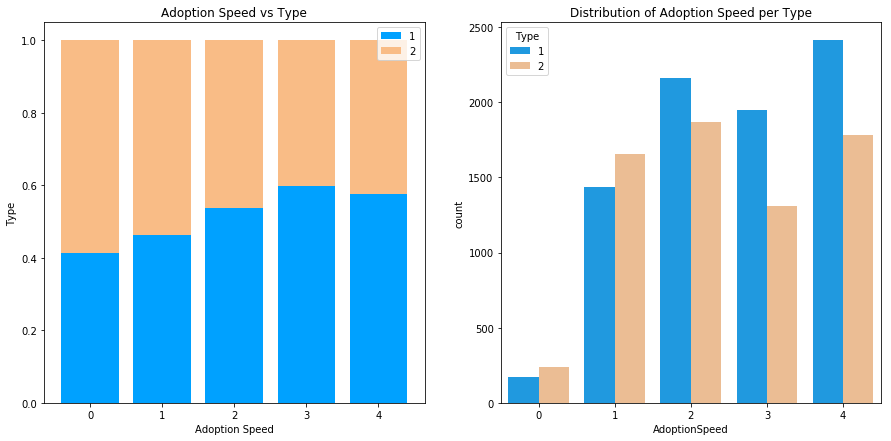

In [10]:
x= 'AdoptionSpeed'
features =["Type"]

for i in features:
    graphics(train,'AdoptionSpeed','Type',ncat=range(0,2))    #1. Dog 2.Cat

-  Type 1: Dog - Type 2: Cat. We see that cats are adopted more faster than dogs. 

#### Gender Analysis 

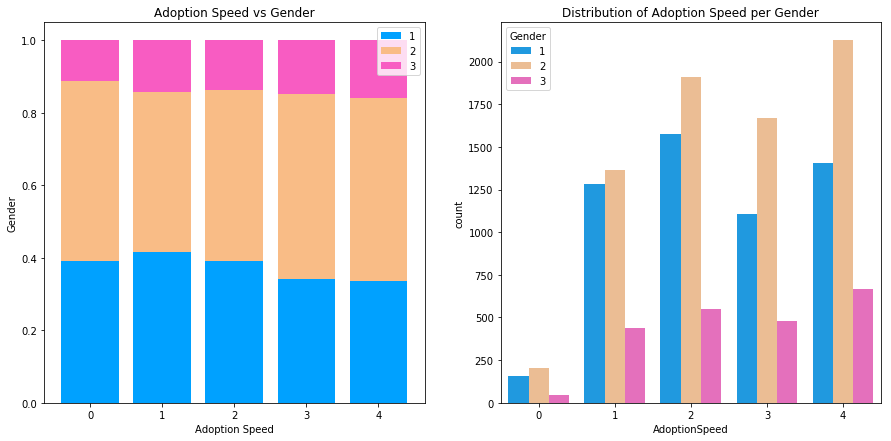

In [11]:
features=["Gender"]
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,3))    #1. Male, 2.Female 3. Mixed

-  More than one animals have tendance to be adopted after

#### Health Analysis

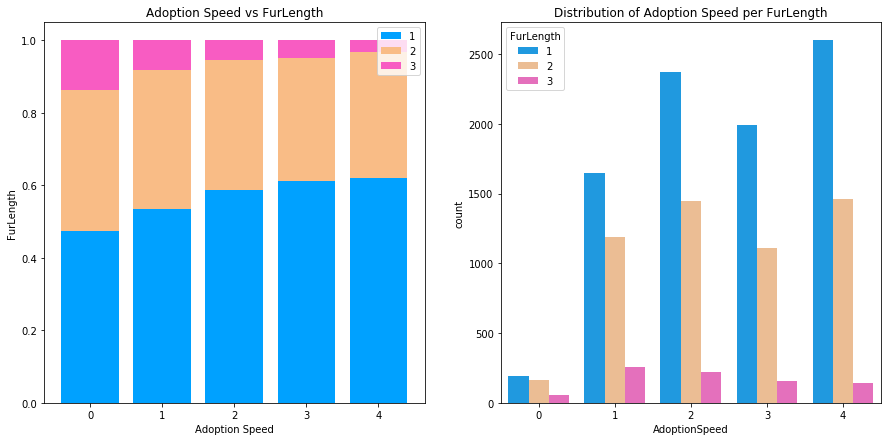

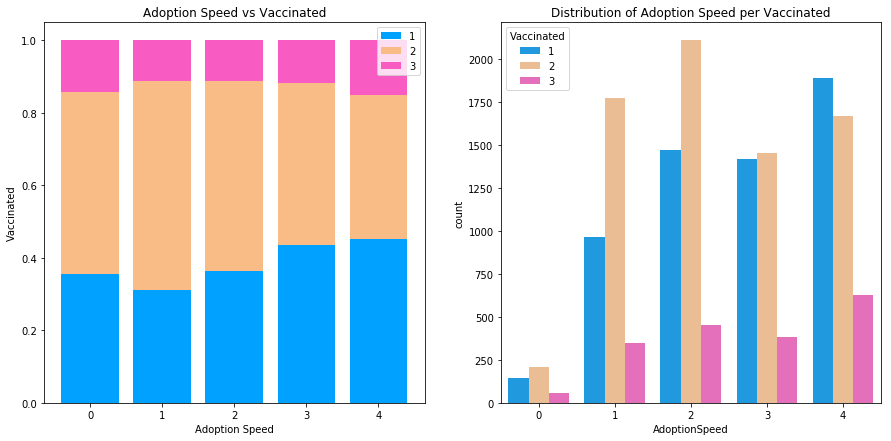

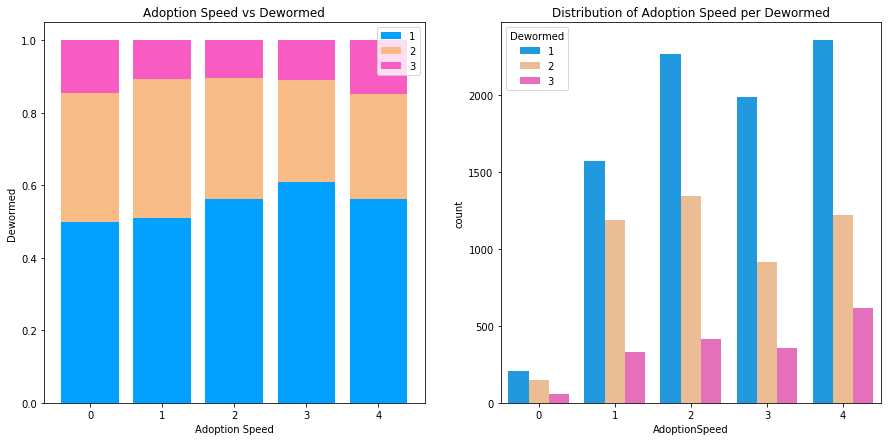

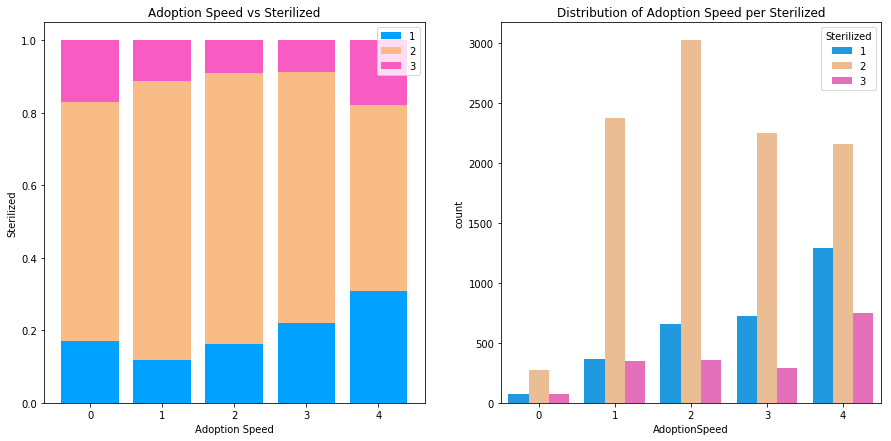

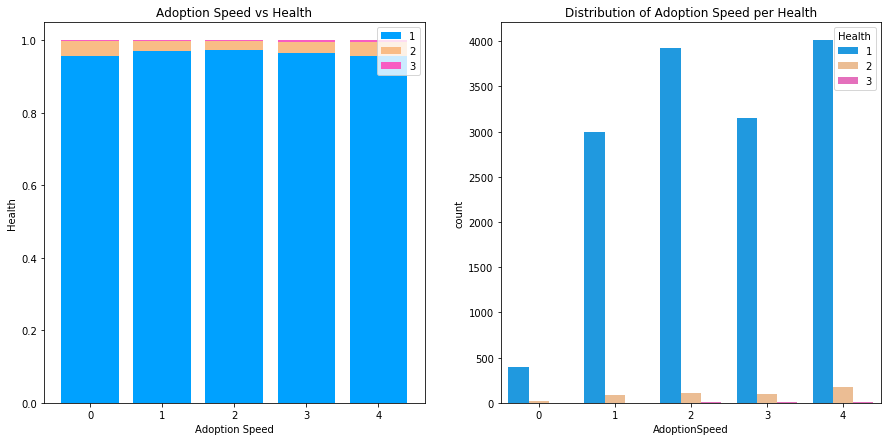

In [12]:
# Draw a nested analysis per Target
features =['FurLength','Vaccinated','Dewormed','Sterilized','Health']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,3))   

In [13]:
# FurLength (0 = Not Specified) - Health (0 = Not Specified) No missing values

train.loc[train['FurLength'] == 0]
train.loc[train['Health'] == 0 ]

Empty DataFrame
Columns: [Type, Name, Age, Breed1, Breed2, Gender, Color1, Color2, Color3, MaturitySize, FurLength, Vaccinated, Dewormed, Sterilized, Health, Quantity, Fee, State, RescuerID, VideoAmt, Description, PetID, PhotoAmt, AdoptionSpeed, BreedName1, BreedName2, ColorName1, ColorName2, ColorName3, StateName, score, L_Color1, L_Color2, L_Color3, L_Breed1, L_Breed2, L_Name_missing, L_Name_incorrect, L_Fee_Free, N_pets_total, L_NoPhoto, L_NoVideo, L_scoreneg]
Index: []

[0 rows x 43 columns]

-  A Longer Fur favorise animal adoption (Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified))
-  Vaccination doesn't seem to have an impact on adoption (1 = Yes, 2 = No, 3 = Not Sure)
-  Dewormed doesn't seem to have an impact on adoption ...
-  Sterilized either, they prefer non sterilized pets?
-  Majority of Pets are healthy and in general they prefer health pets. 

#### Age & Mature Size analysis

In [14]:
#Count how many pets per Age (months) and Adoption Speed group
grouped_data = train.groupby(['AdoptionSpeed'])
grouped_data['Age'].describe()

count       mean        std  min  25%  50%   75%    max
AdoptionSpeed                                                          
0               410.0  10.451220  17.775118  0.0  2.0  3.0  12.0  120.0
1              3090.0   8.488350  15.746187  0.0  2.0  2.0   6.0  147.0
2              4036.0   8.825074  16.780842  0.0  2.0  3.0   6.0  156.0
3              3257.0  10.194965  18.676734  0.0  2.0  3.0   9.0  212.0
4              4195.0  13.656257  20.161605  0.0  3.0  6.0  15.0  255.0

-  The dataset contains young pets, 50% of them have less than 6 months.
-  We see that older pets are adopted slower or not adopted

Index([1, 2, 3, 4, 'All'], dtype='object', name='MaturitySize')


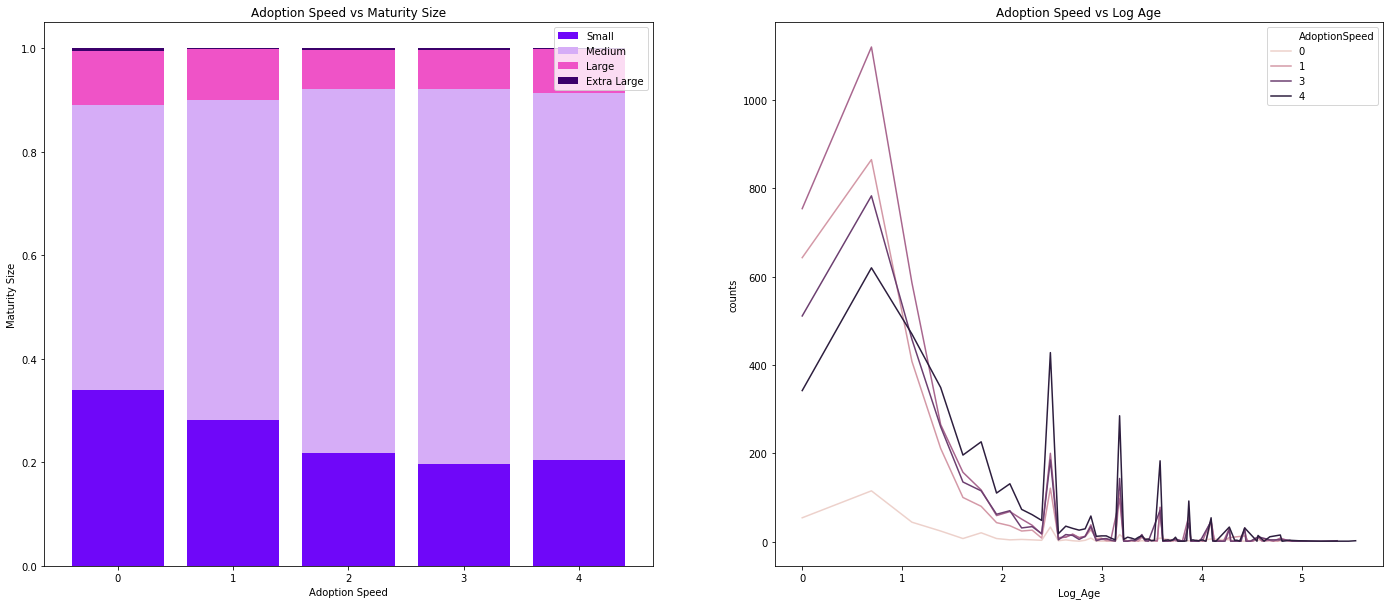

In [30]:
age_analysis =train.groupby(['Log_Age', 'AdoptionSpeed']).size().reset_index(name='counts')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,10))

sns.lineplot(x="Log_Age", y="counts", hue = "AdoptionSpeed",data=age_analysis).set_title("Adoption Speed vs Log Age")
# CrossTab
cross = pd.crosstab(train["AdoptionSpeed"],train['MaturitySize'],margins=True)
# Delete the All obs. per variable y
cross = cross.drop(cross.index[len(cross)-1])
print(cross.columns)
# Stacked Bar Plot
Type1 = pd.DataFrame(cross[1]/cross['All'])
Type2 = pd.DataFrame(cross[2]/cross['All'])
Type3 = pd.DataFrame(cross[3]/cross['All'])
Type4 = pd.DataFrame(cross[4]/cross['All'])

ax1.bar(Type1.index.values, Type1[0], label='Small', color='#6f07f9')
ax1.bar(Type2.index.values, Type2[0], bottom=Type1[0], color='#d6adf7', label='Medium')
ax1.bar(Type3.index.values, Type3[0], bottom=[z+t for z,t in zip(Type1[0], Type2[0])], label='Large', color='#ef53c7')
ax1.bar(Type4.index.values, Type4[0], bottom=[s+t+z for s,z,t in zip(Type1[0], Type2[0],Type3[0])], label='Extra Large', color='#3b006b')

# Add title and axis names
ax1.set_title('Adoption Speed vs Maturity Size')
ax1.set(xlabel='Adoption Speed', ylabel="Maturity Size")
ax1.legend(loc='upper right')


-  Small and Large pets are adopted faster

#### Color pets analysis

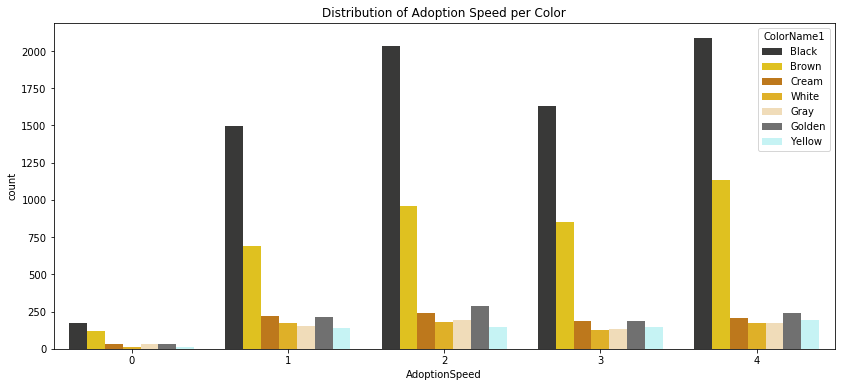

In [16]:
plt.figure(figsize=(14,6))
sns.countplot(x="AdoptionSpeed",hue="ColorName1", data=train,palette=('#393938','#ffd700','#d87c01',"#febf09","#f9dfb0","#707070","#befbfc")).set_title('Distribution of Adoption Speed per Color')

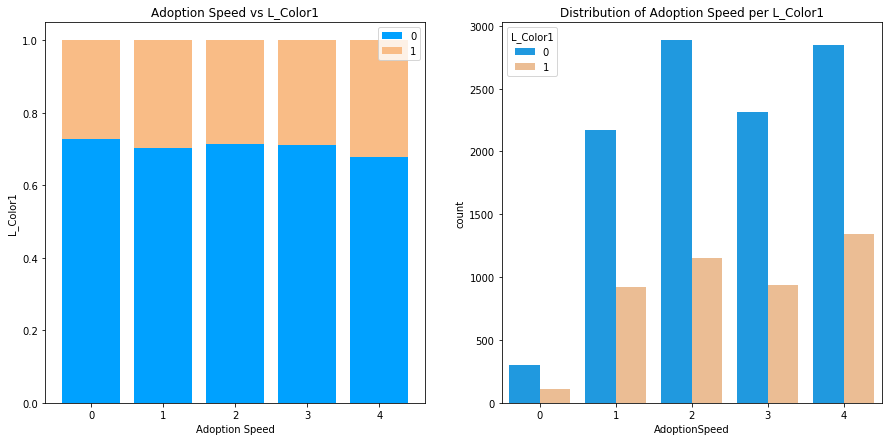

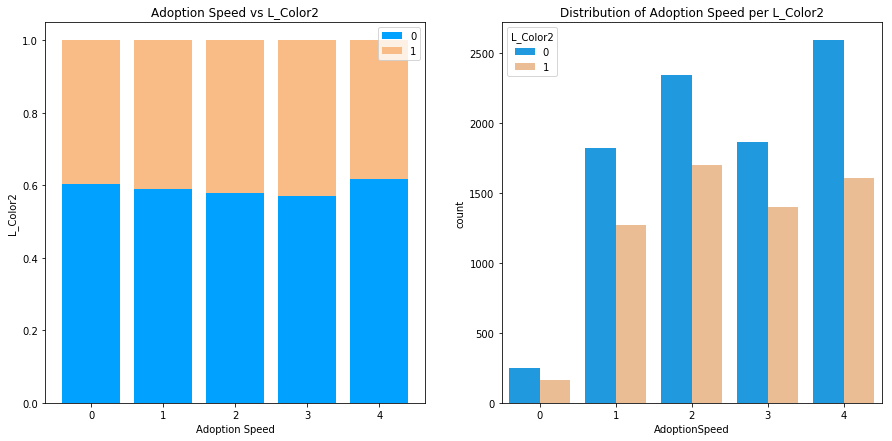

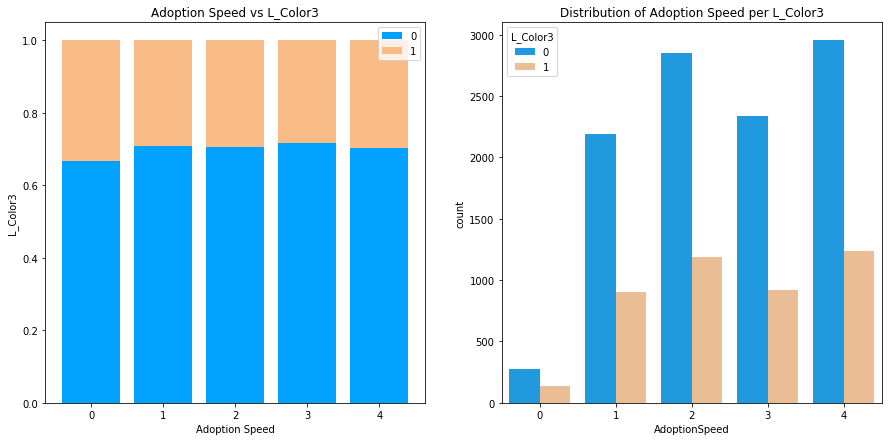

In [17]:
# Draw a nested analysis per Target
features =['L_Color1','L_Color2','L_Color3']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,2))   

-  1 Color or multiple colors doesn't seem to have an impact on Adoption Speed

#### Breed analysis

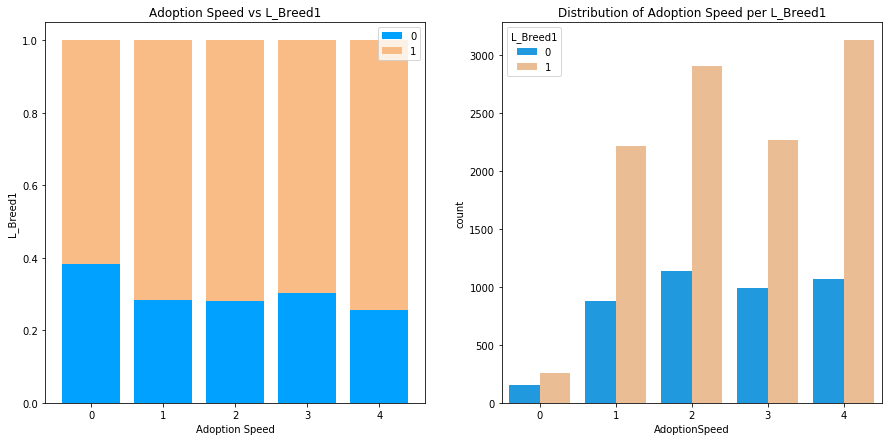

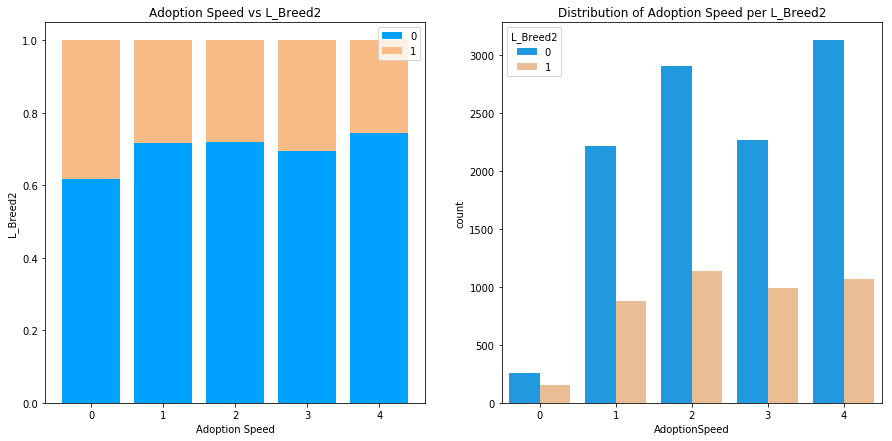

In [18]:
# Draw a nested analysis per Target
features =['L_Breed1','L_Breed2']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,2))   

-  Cat or dog with 2 breeds may have higher speed adption

#### Fee Adoption 

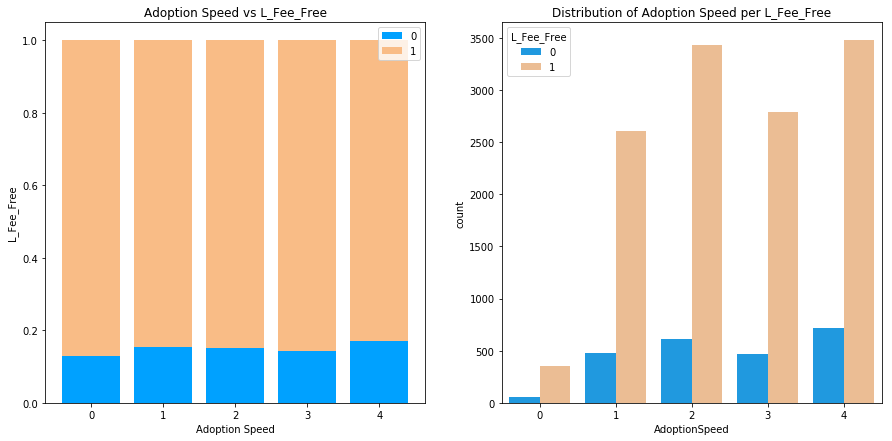

In [19]:
# Free Adoption 
features =['L_Fee_Free']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,2))   

-  Most animals are charge free 

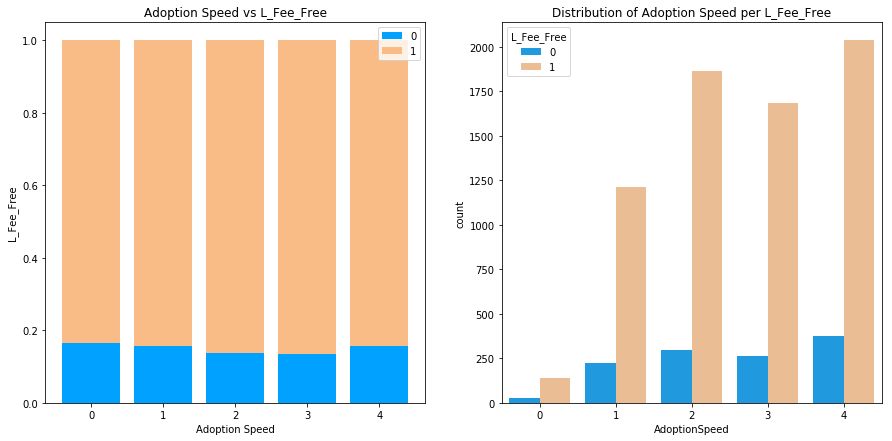

In [20]:
# Free Adoption Dogs 
features =['L_Fee_Free']
target = ['AdoptionSpeed']
for i in features:
    graphics(train.query('Type==1'),"AdoptionSpeed",i,ncat=range(0,2))   

Dogs freeness doesn't seem to impact the adoption

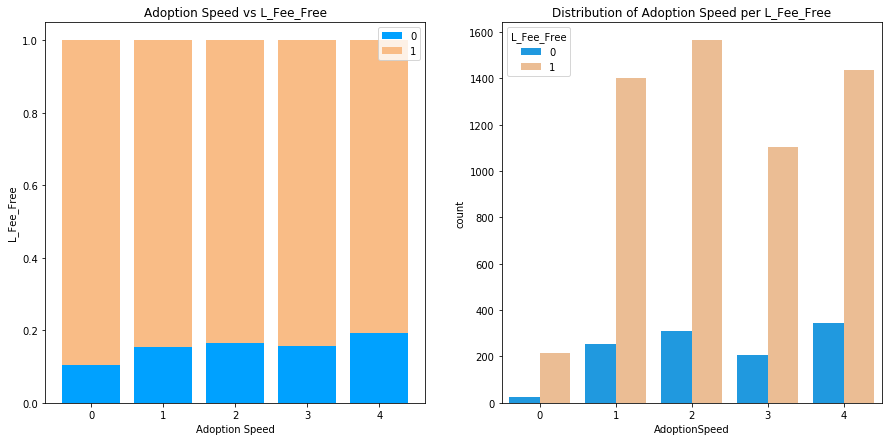

In [21]:
# Free Adoption Cats 
features =['L_Fee_Free']
target = ['AdoptionSpeed']
for i in features:
    graphics(train.query('Type==2'),"AdoptionSpeed",i,ncat=range(0,2))   

In [22]:
fee_analysis =train.query('Fee>0').groupby(['AdoptionSpeed'])
fee_analysis['Fee'].describe()


count        mean         std  min   25%    50%    75%     max
AdoptionSpeed                                                                
0               53.0  170.849057  184.041320  1.0  50.0  100.0  200.0  1000.0
1              479.0  140.774530  163.265164  1.0  50.0  100.0  200.0  2000.0
2              607.0  143.540362  156.574884  1.0  50.0  100.0  200.0  1000.0
3              469.0  140.027719  185.578252  1.0  50.0  100.0  200.0  3000.0
4              720.0  124.113889  115.791373  1.0  50.0  100.0  160.0   750.0

-  The result is interesting for No adoption after 100 days the fee is less higher (in mean) than for the Adoption between 1 and 10 days 
- Free cats seems to be adopted faster

#### State analysis

<img src="https://i.imgur.com/NWIf9Gf.png" alt="state" title="state" width="600" height="400" /> 

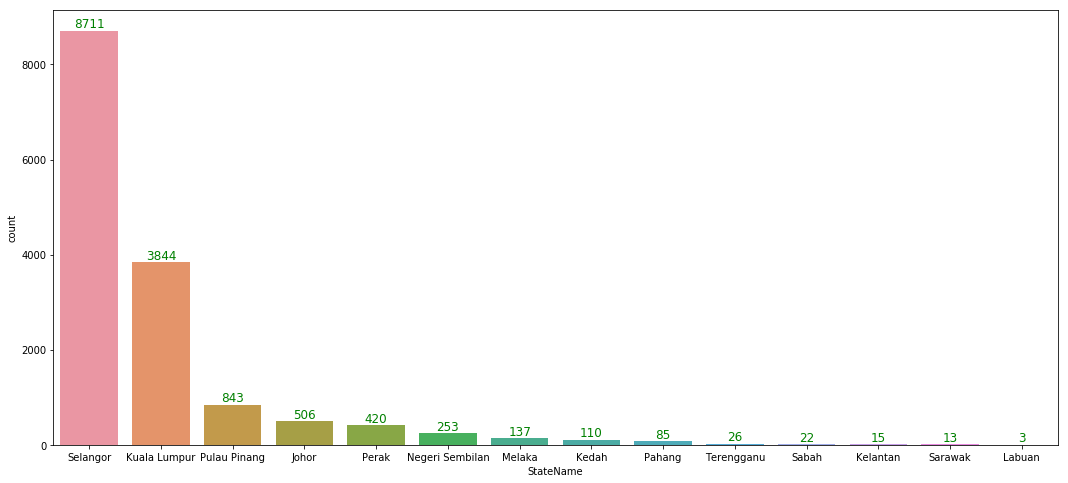

In [23]:
fig= plt.subplots(figsize=(18,8))
ax = sns.countplot(x="StateName", data=train, order = train["StateName"].value_counts().index)
# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='green', ha='center', va='bottom')

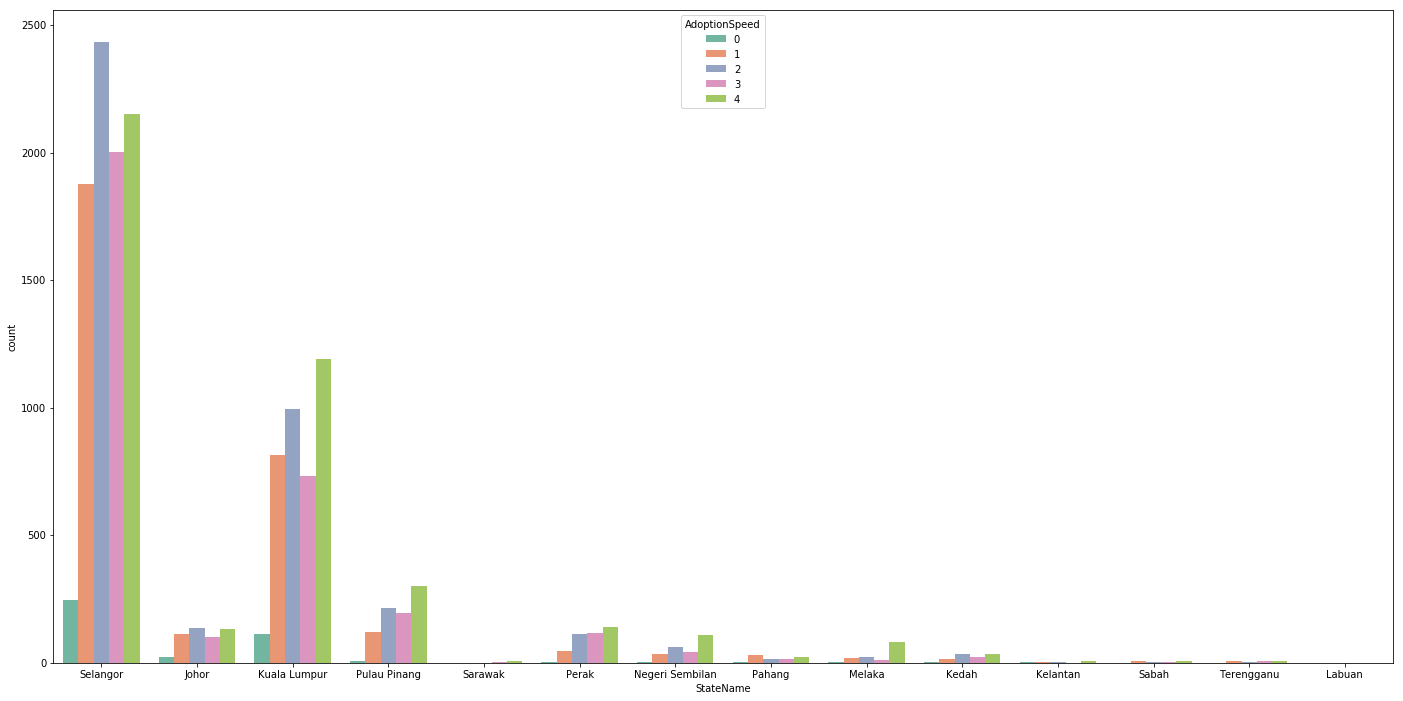

In [24]:
fig= plt.subplots(figsize=(24,12))
ax = sns.countplot(x="StateName",  hue="AdoptionSpeed",data=train, palette="Set2")

-  In Kuala Lumpur and Pulau Pinang the process seems slower 
-  Selangor is the suburb of Kuala Lumpur

#### RescuerID analysis

Number of pets per Rescuer and List the Top 10 Rescuer

In [25]:
rescuer_analysis =train.groupby(['RescuerID']).size().reset_index(name='counts')
rescuer_analysis['counts'].describe()

count    5592.000000
mean        2.680258
std        10.387263
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       459.000000
Name: counts, dtype: float64

-  In mean a Rescuer have around 2 pets, let's see the top Rescuer ! 

In [26]:
Top4 =rescuer_analysis.sort_values('counts',ascending=False).head(4)
Top4

RescuerID  counts
5482  fa90fa5b1ee11c86938398b60abc32cb     459
3766  aa66486163b6cbc25ea62a34b11c9b91     315
4226  c00756f2bdd8fa88fc9f07a8309f7d5d     231
3994  b53c34474d9e24574bcec6a3d3306a0d     228

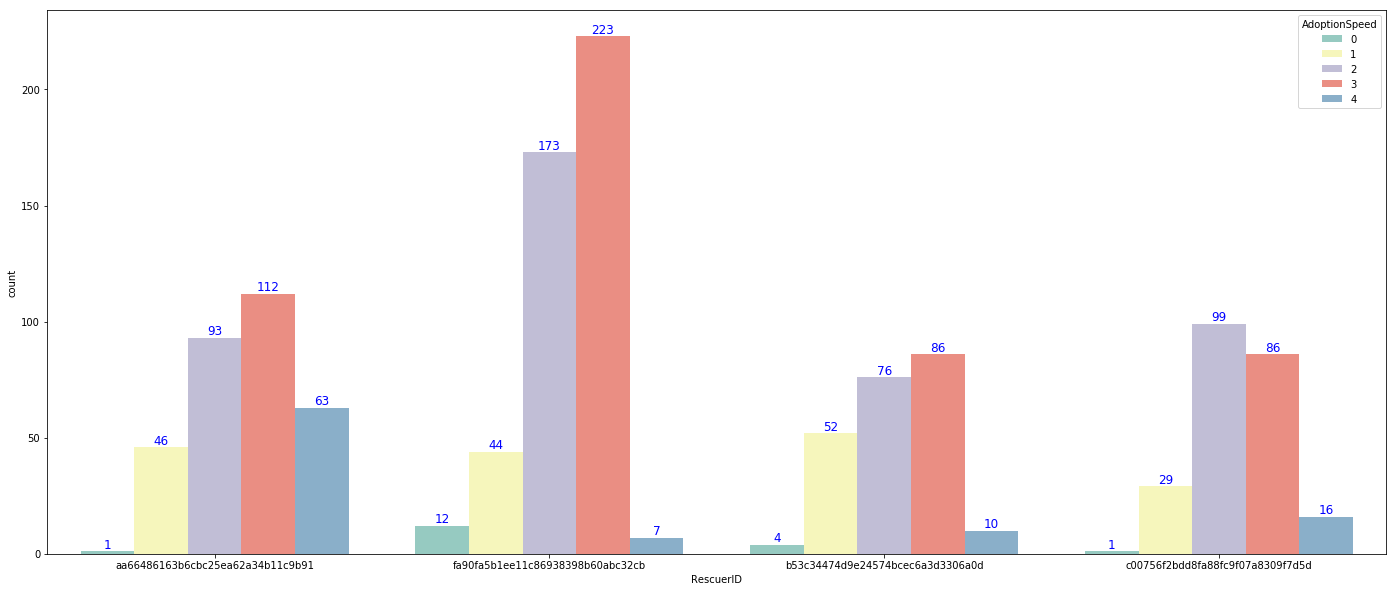

In [27]:
train_toprescuer = train.loc[train['RescuerID'].isin(Top4['RescuerID'].values.tolist())]

fig = plt.subplots(figsize=(24,10))

ax = sns.countplot(x="RescuerID",data=train_toprescuer ,hue="AdoptionSpeed" ,palette="Set3")
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='blue', ha='center', va='bottom') 

- the First Rescuer seems to have faster adoption

###### Rescuer with more pets have higher Adoption Rate? YES!

In [28]:
# Best Rescuer for minimum 10 pets
rescuer_speed =train.groupby(['RescuerID','AdoptionSpeed']).size().reset_index(name='N_pets_speed')

pets_total = train.groupby(['RescuerID']).size().reset_index(name='N_pets_total')
rescuer_analysis= pd.merge(pets_total, rescuer_speed, left_on='RescuerID', right_on='RescuerID', how='inner')
rescuer_analysis['pct_pets'] = rescuer_analysis['N_pets_speed']/rescuer_analysis['N_pets_total']

#Big Rescuer
rescuer_analysis.query("N_pets_total>10").groupby("AdoptionSpeed")['pct_pets'].describe().reset_index()


AdoptionSpeed  count      mean       std       min       25%       50%  \
0              0   56.0  0.092211  0.100268  0.003175  0.033065  0.064583   
1              1  151.0  0.261362  0.171193  0.027027  0.125271  0.214286   
2              2  167.0  0.329816  0.140831  0.040000  0.230769  0.337838   
3              3  163.0  0.262902  0.136225  0.024390  0.156923  0.250000   
4              4  123.0  0.271856  0.238099  0.015251  0.080128  0.187500   

        75%       max  
0  0.092572  0.500000  
1  0.360390  0.750000  
2  0.416667  0.733333  
3  0.354248  0.714286  
4  0.366029  1.000000

In [29]:
#Small Rescuer
rescuer_analysis.query("N_pets_total<10").groupby("AdoptionSpeed")['pct_pets'].describe().reset_index()

AdoptionSpeed   count      mean       std       min  25%  50%  75%  max
0              0   252.0  0.716601  0.333763  0.111111  0.4  1.0  1.0  1.0
1              1  1423.0  0.739264  0.303898  0.111111  0.5  1.0  1.0  1.0
2              2  1538.0  0.750468  0.301336  0.111111  0.5  1.0  1.0  1.0
3              3  1201.0  0.722105  0.313204  0.111111  0.5  1.0  1.0  1.0
4              4  2424.0  0.882003  0.243132  0.111111  1.0  1.0  1.0  1.0

#### Video and Photo Analysis

In [30]:
train['PhotoAmt'].describe()

count    14988.000000
mean         3.888911
std          3.487733
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         30.000000
Name: PhotoAmt, dtype: float64

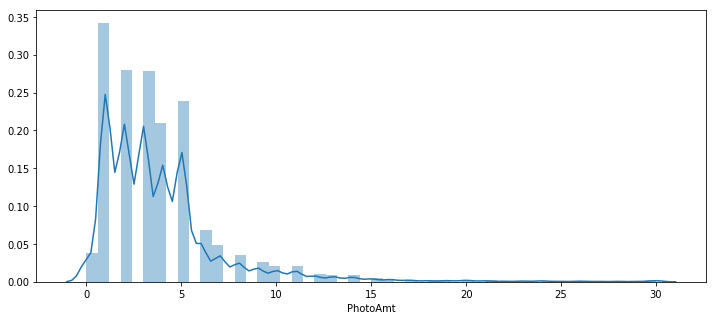

In [31]:
fig = plt.subplots(figsize=(12,5))
sns.distplot(train['PhotoAmt'])

In [32]:
train.groupby('AdoptionSpeed')['PhotoAmt'].mean()

AdoptionSpeed
0    3.324390
1    3.727184
2    4.070119
3    4.622659
4    3.319190
Name: PhotoAmt, dtype: float64

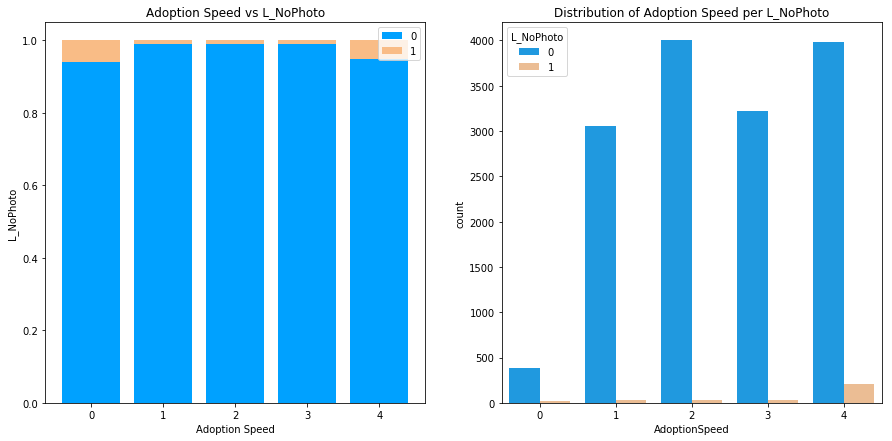

In [33]:
# Photo? 
features =['L_NoPhoto']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,2))   

In [34]:
train['VideoAmt'].describe()

count    14988.000000
mean         0.056779
std          0.346241
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: VideoAmt, dtype: float64

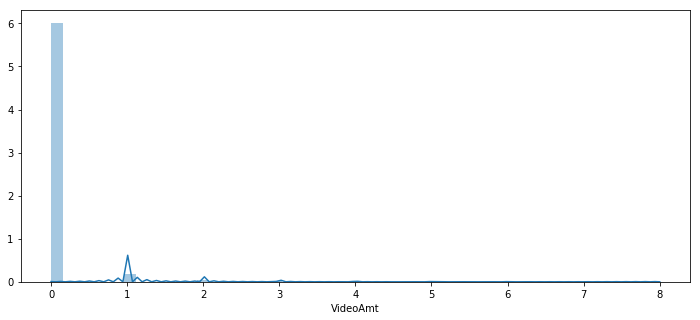

In [35]:
fig = plt.subplots(figsize=(12,5))
sns.distplot(train['VideoAmt'])

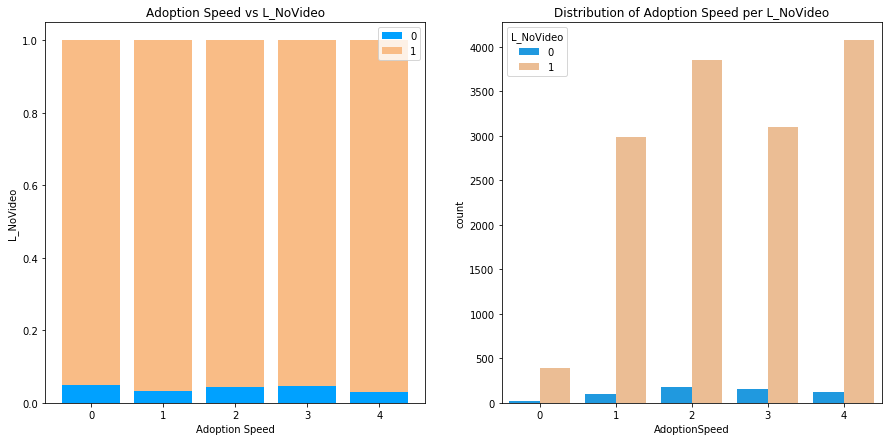

In [36]:
# Video? 
features =['L_NoVideo']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,2))   

-  Video and Photo Amount doesn't seem to have a huge impact on Adoption Speed

#### Quantity Analysis

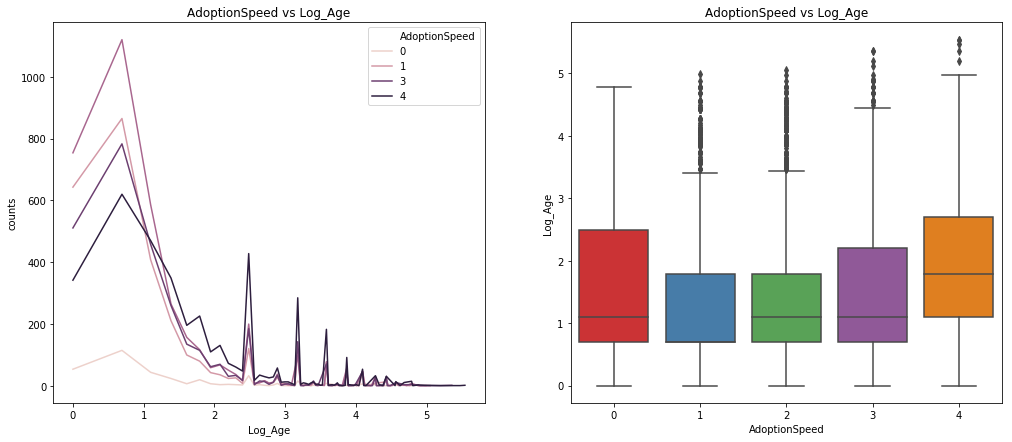

In [59]:
graphics_num(train,'AdoptionSpeed','Log_Age')

We saw that more than 5 pets it seems extreme values. The description as example is **6 precious little puppies up for adoption. 4 males, 2 females...** proposing one or more puppies 

#### Sentiment Data Analysis

In [66]:
train.groupby('AdoptionSpeed')['sentiment_document_score'].mean()

AdoptionSpeed
0    0.296094
1    0.266633
2    0.274475
3    0.274433
4    0.301415
Name: sentiment_document_score, dtype: float64

In [67]:
train.groupby('AdoptionSpeed')['sentiment_document_magnitude'].mean()

AdoptionSpeed
0    1.815104
1    2.112208
2    2.176728
3    2.283186
4    1.998411
Name: sentiment_document_magnitude, dtype: float64

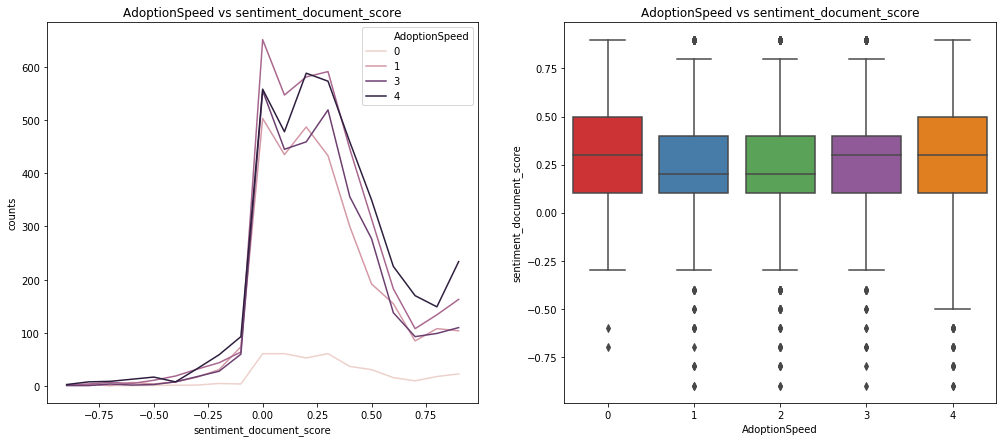

In [60]:
graphics_num(train,'AdoptionSpeed','sentiment_document_score')

-  We see some more negative score when the Adoption is slower
-  Thus we create variable negative Score 

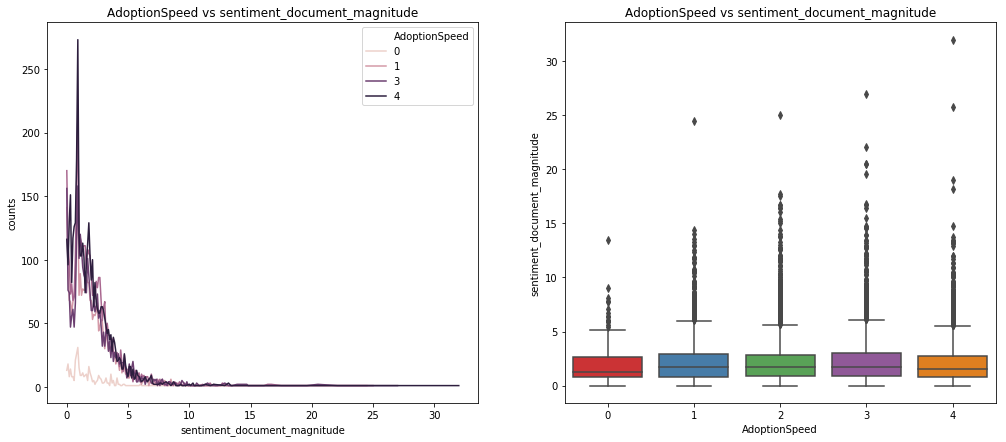

In [61]:
graphics_num(train,'AdoptionSpeed','sentiment_document_magnitude')

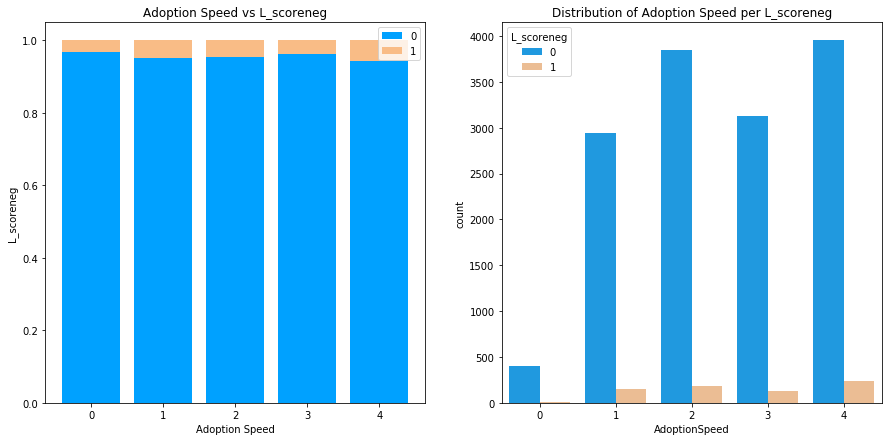

In [39]:
features =['L_scoreneg']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,2))   

#### Pet's Name Analysis

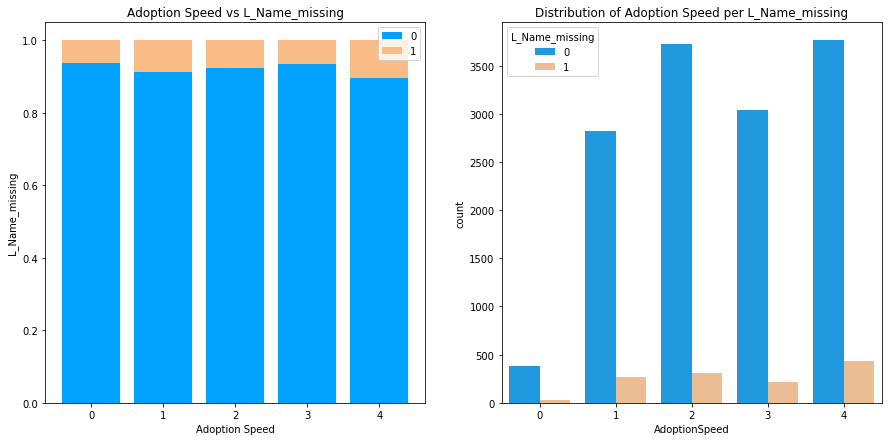

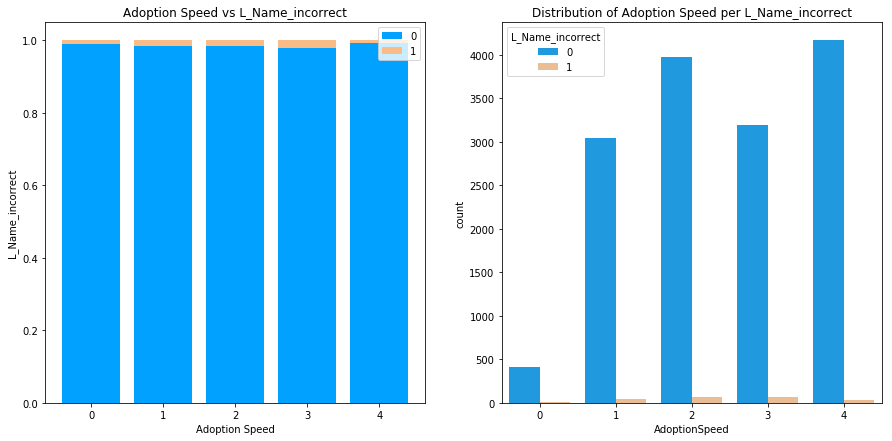

In [40]:
#Impact on missing name or incorrect name

features =['L_Name_missing','L_Name_incorrect']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,2))   

-  Missing Name has an impact on Adoption Speed. Let's Analyse the Name !

In [41]:
train_dog=train.loc[train['Type'] == 1]
train_cat=train.loc[train['Type'] == 2]

text_cat = ','.join(str(v) for v in train_cat.Name)
text_dog = ','.join(str(v) for v in train_dog.Name)
print ("There are {} words in the combination of all Name.".format(len(text_dog)))

There are 77955 words in the combination of all Name.


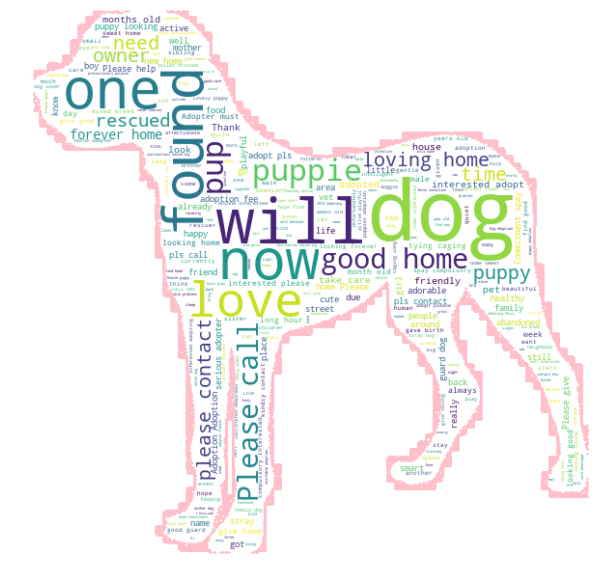

In [52]:
response_cat = requests.get("https://i.imgur.com/VIUvAxb.jpg")
cat_mask = np.array(Image.open(BytesIO(response_cat.content)))
response_dog = requests.get("https://i.imgur.com/IWGYuPN.jpg")
dog_mask = np.array(Image.open(BytesIO(response_dog.content)))

#dog_mask = np.array(Image.open(r"C:\Users\alorenzodebrionne\Pictures\dog.jpg"))
#cat_mask= np.array(Image.open(r"C:\Users\alorenzodebrionne\Pictures\cat.jpg"))

def word_cloud(text,mask):
    # Create a word cloud image
    wc = WordCloud(background_color="white", max_words=300, mask=mask,
                   contour_width=3, contour_color='pink')

    # Generate a wordcloud
    wc.generate(text)

    # show
    plt.figure(figsize=[20,10])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

word_cloud(text_dog,dog_mask)

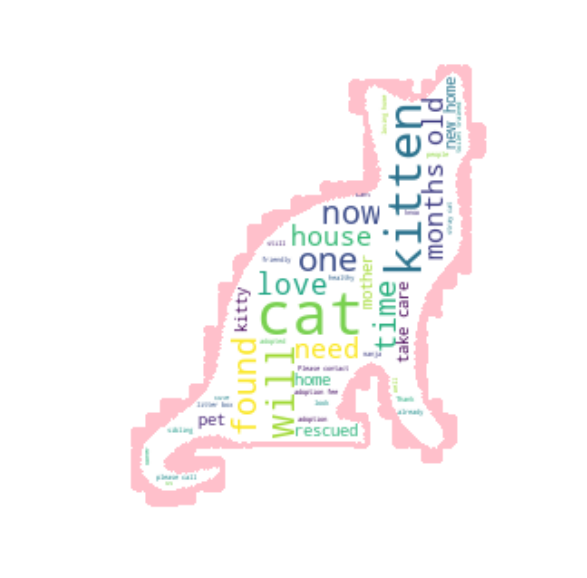

In [53]:
word_cloud(text_cat,cat_mask)

#### Image Metadata Analysis

<img src="https://i.imgur.com/iTSmFys.jpg" alt="pet" title="pet" width="400" height="300" />  Google API description : dog, dog breed, street dog, dog like mammal, dog breed group, snout, carnivoran...

In [54]:
text_cat = ','.join(str(v) for v in train_cat.Description)
text_dog = ','.join(str(v) for v in train_dog.Description)
print ("There are {} words in the combination of all Description for Cats.".format(len(text_cat)))

There are 2415831 words in the combination of all Description for Cats.


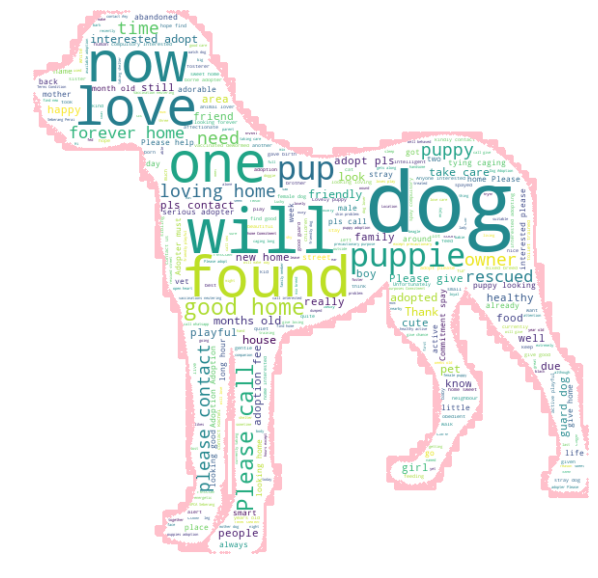

In [55]:
word_cloud(text_dog,dog_mask)

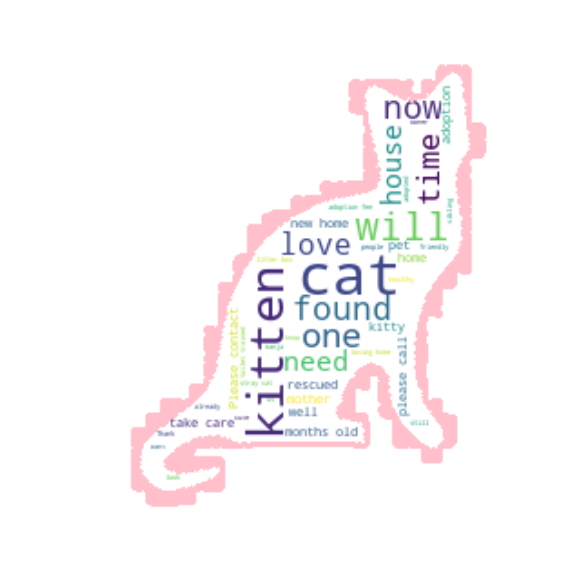

In [56]:
word_cloud(text_cat,cat_mask)

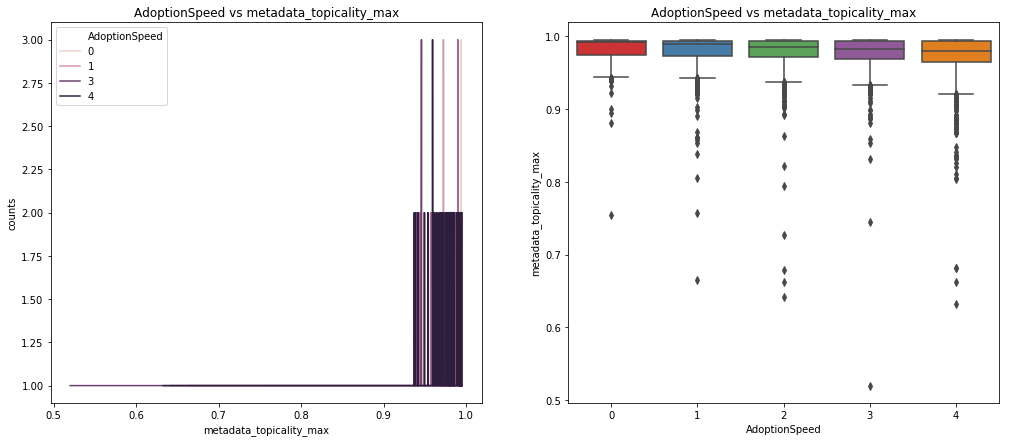

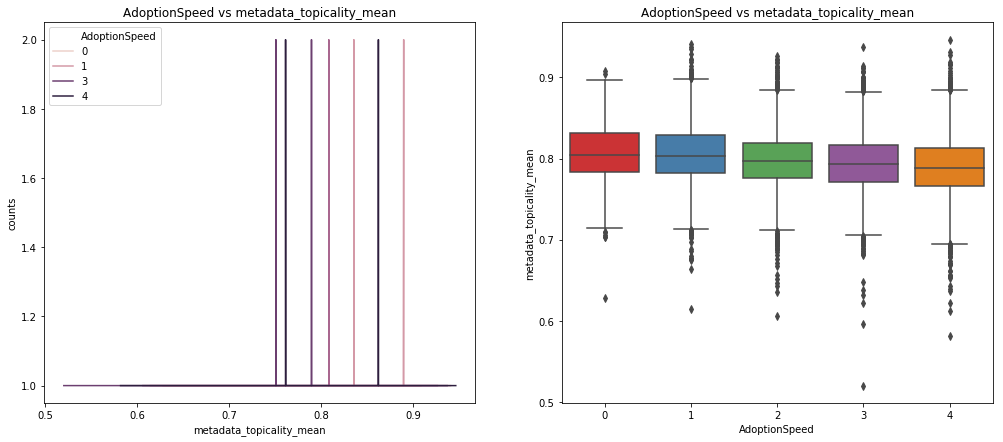

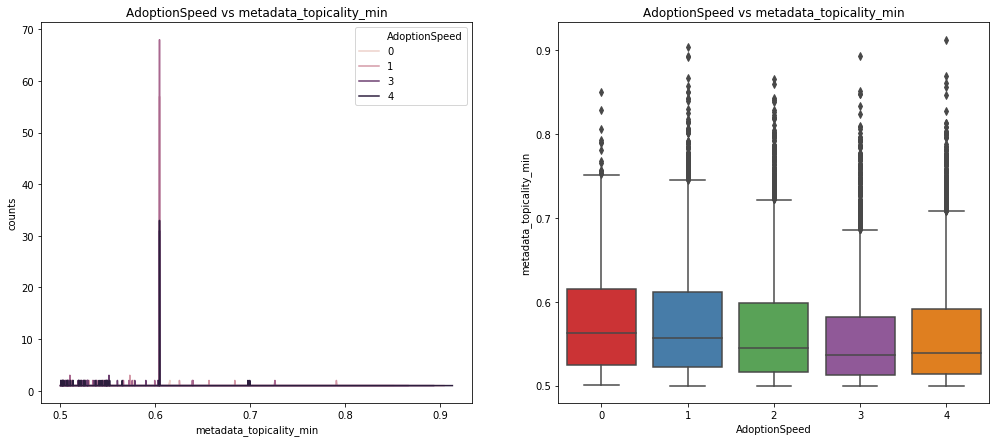

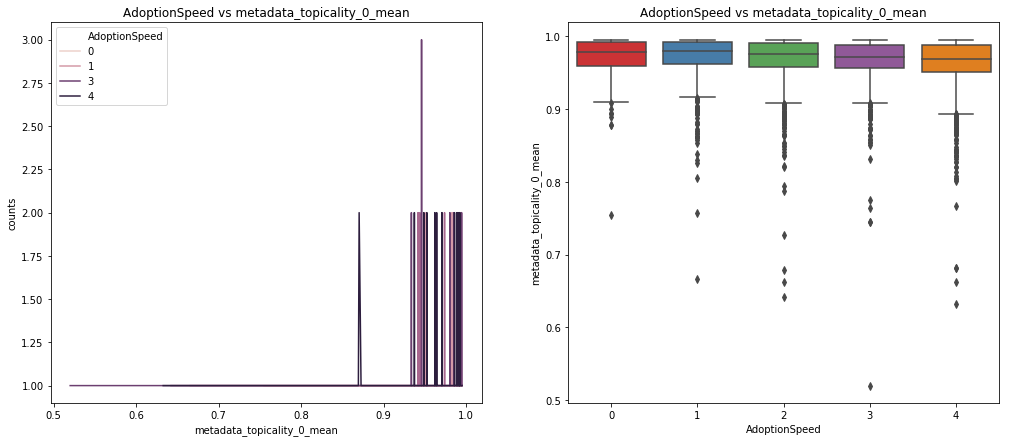

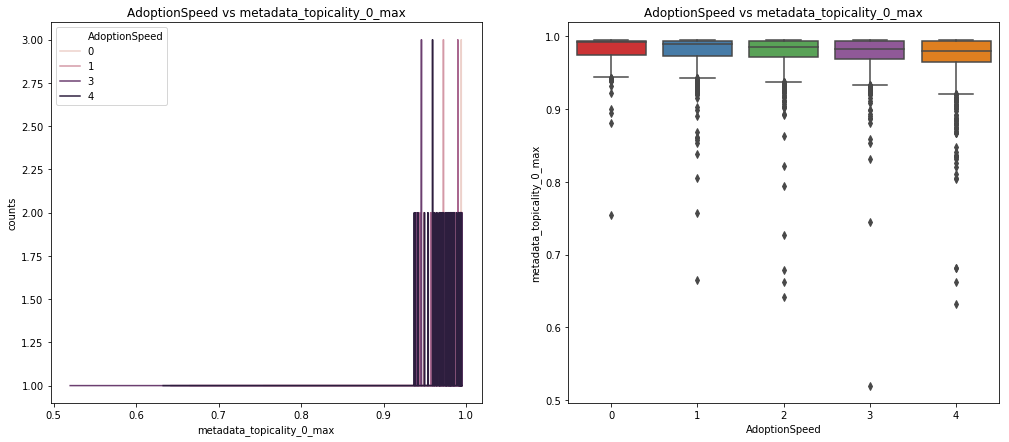

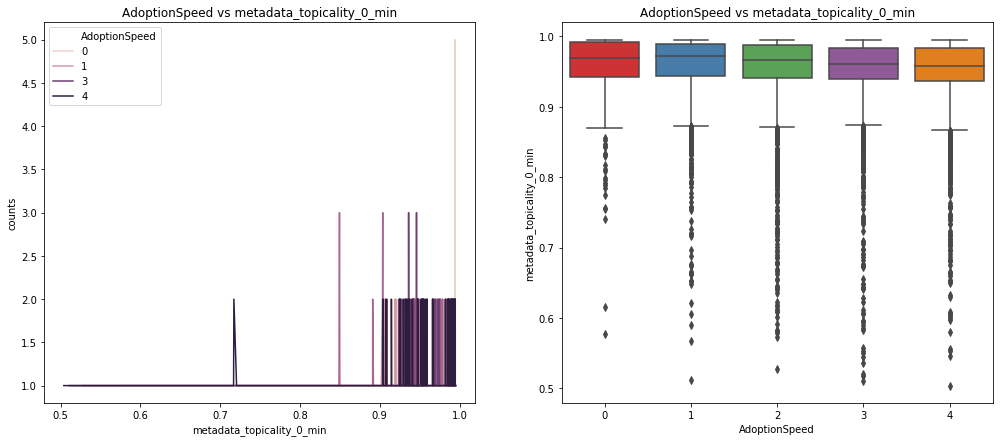

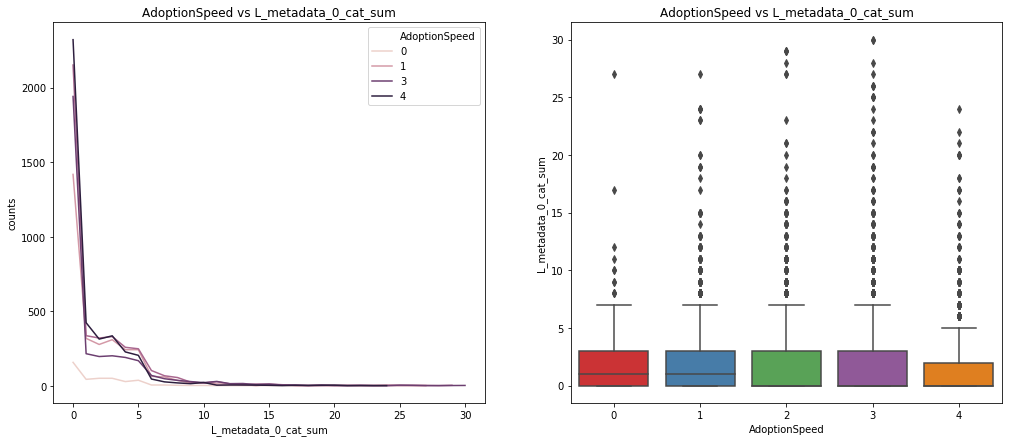

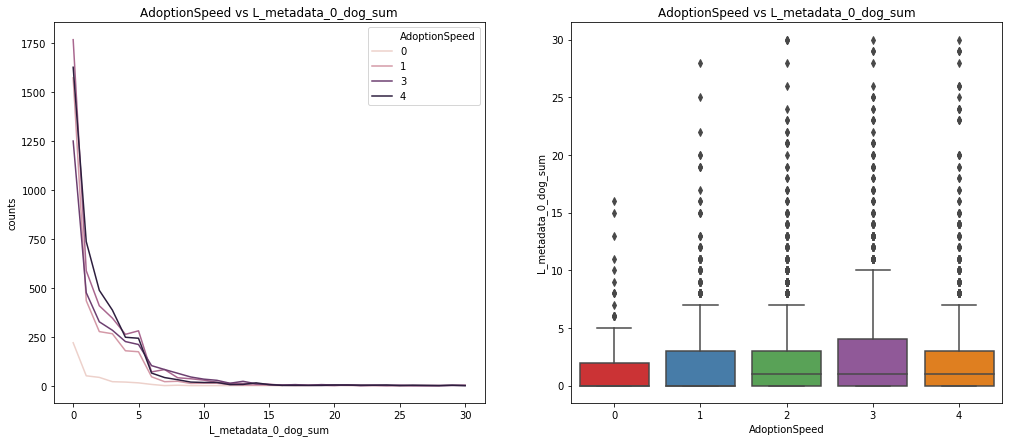

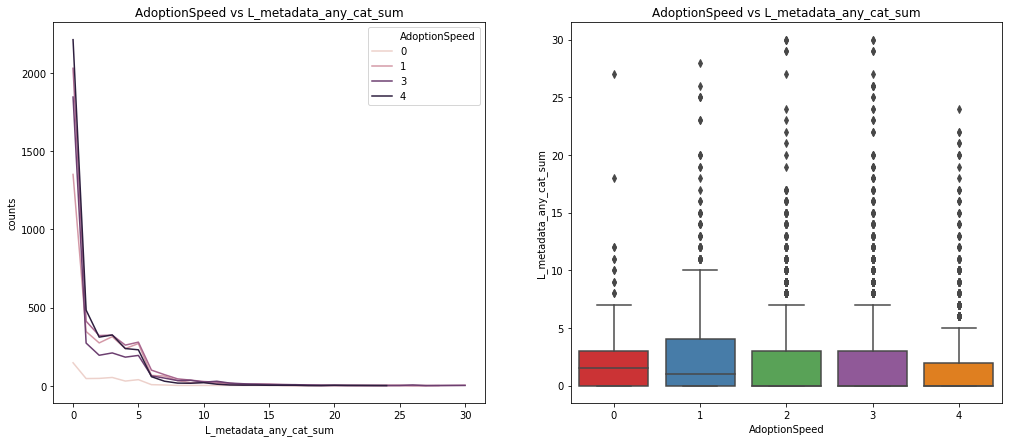

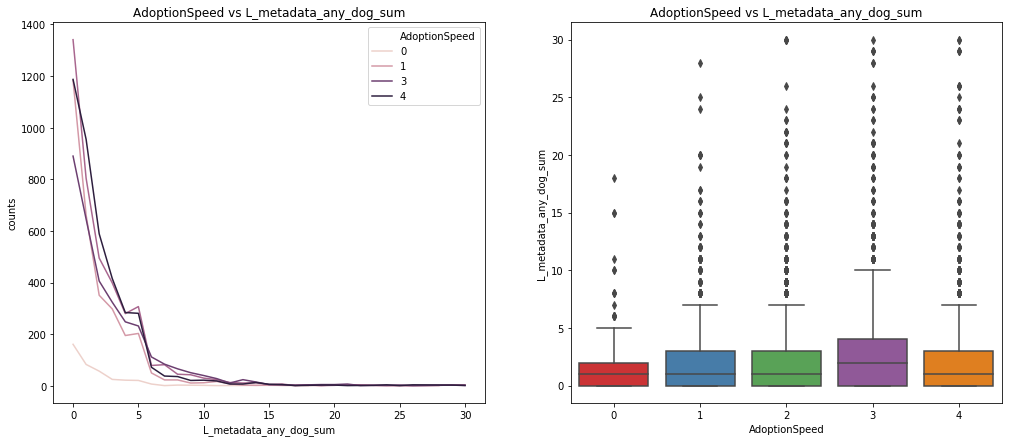

In [62]:
# Draw a nested analysis per Target
features =['metadata_topicality_max','metadata_topicality_mean','metadata_topicality_min','metadata_topicality_0_mean','metadata_topicality_0_max','metadata_topicality_0_min','L_metadata_0_cat_sum','L_metadata_0_dog_sum','L_metadata_any_cat_sum','L_metadata_any_dog_sum']
target = ['AdoptionSpeed']
for i in features:
    graphics_num(train,"AdoptionSpeed",i)   

A higher "Topicality" means a faster Adoption. 
Also if the first object see is a cat or a dog have an impact on Adoption Speed.

#### Image Quality Analysis

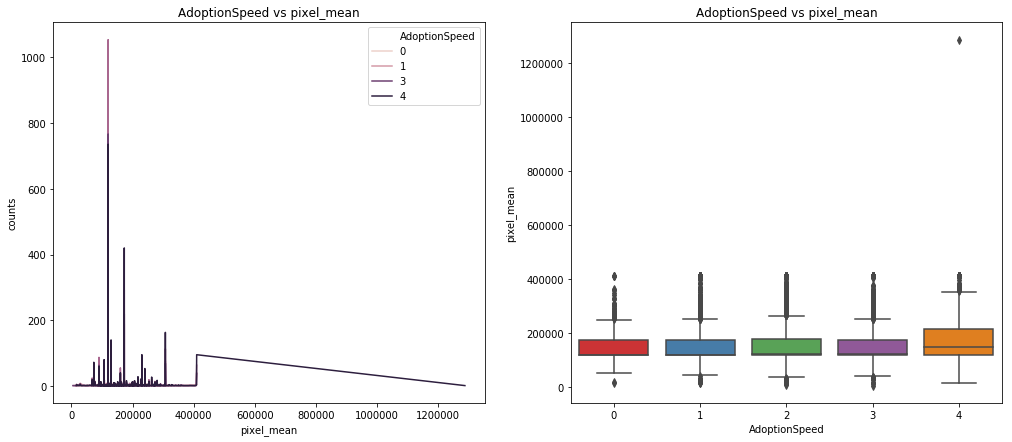

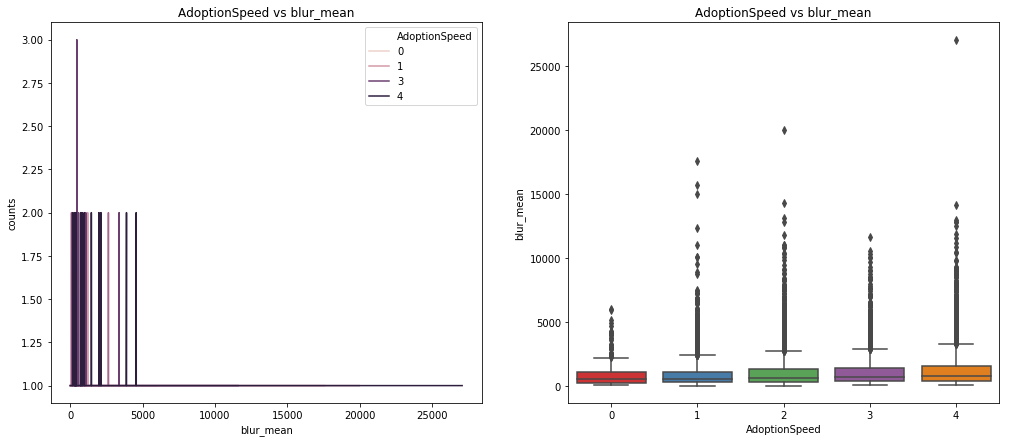

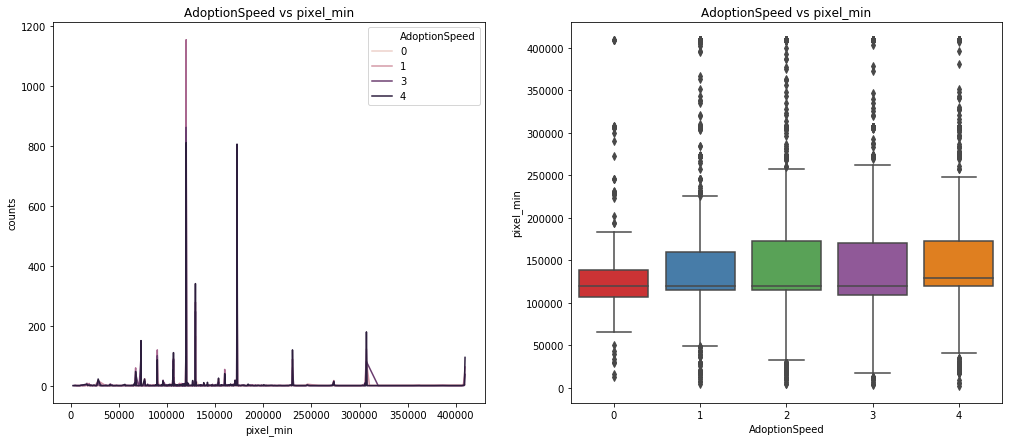

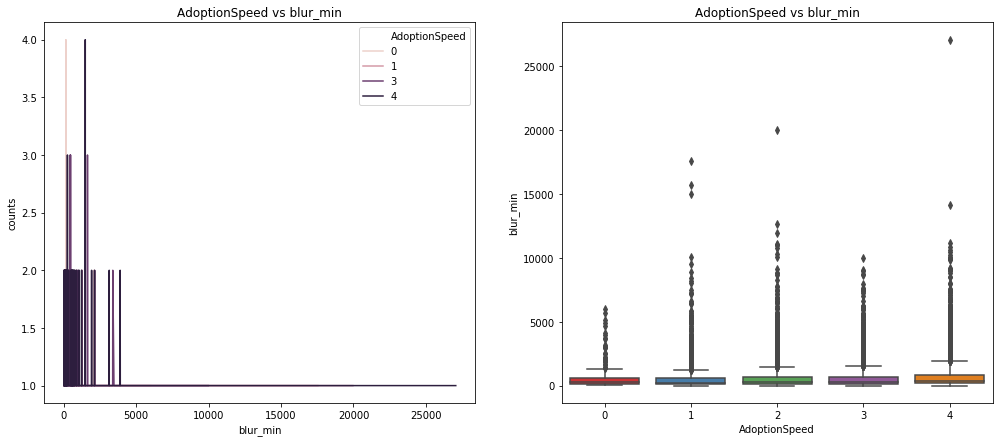

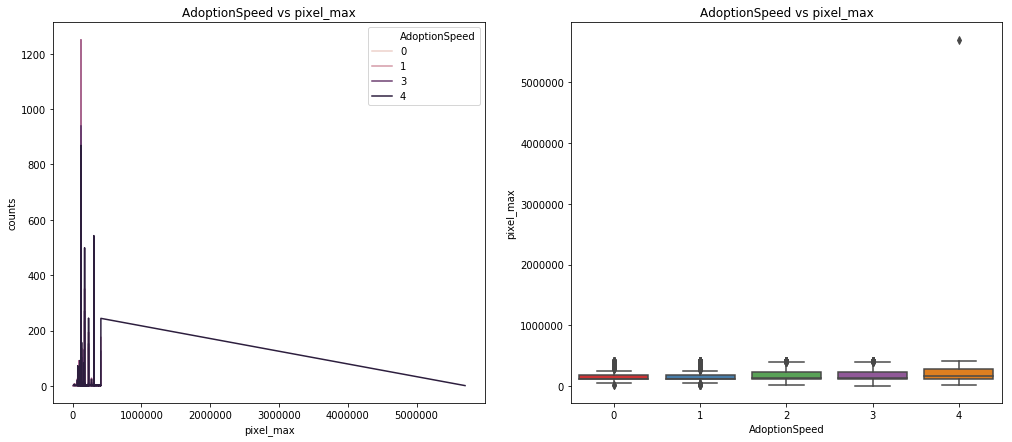

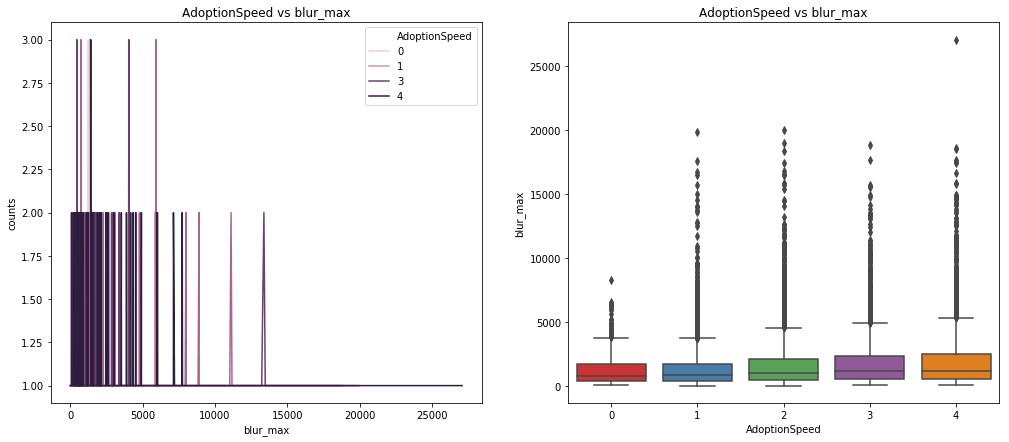

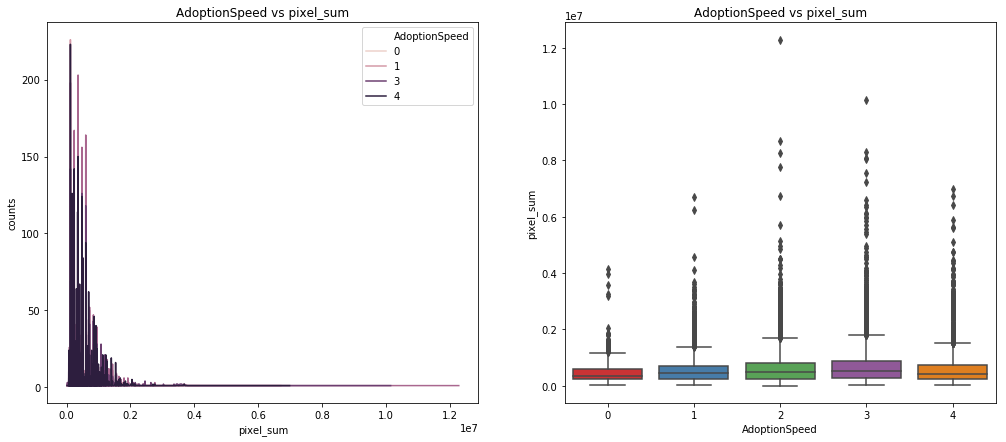

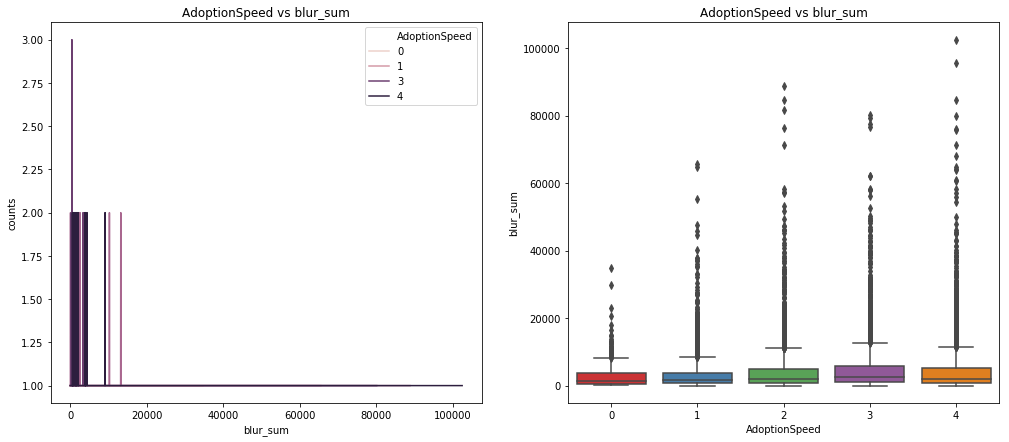

In [63]:
# Draw a nested analysis per Target
features =['pixel_mean','blur_mean','pixel_min','blur_min','pixel_max','blur_max','pixel_sum','blur_sum']
for i in features:
    graphics_num(train,"AdoptionSpeed",i)

Pixels or Blur seem to have no impact on Adoption Speed

## Correlation Matrix

In [62]:
def plot_correlation_matrix(df):
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(30, 15))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

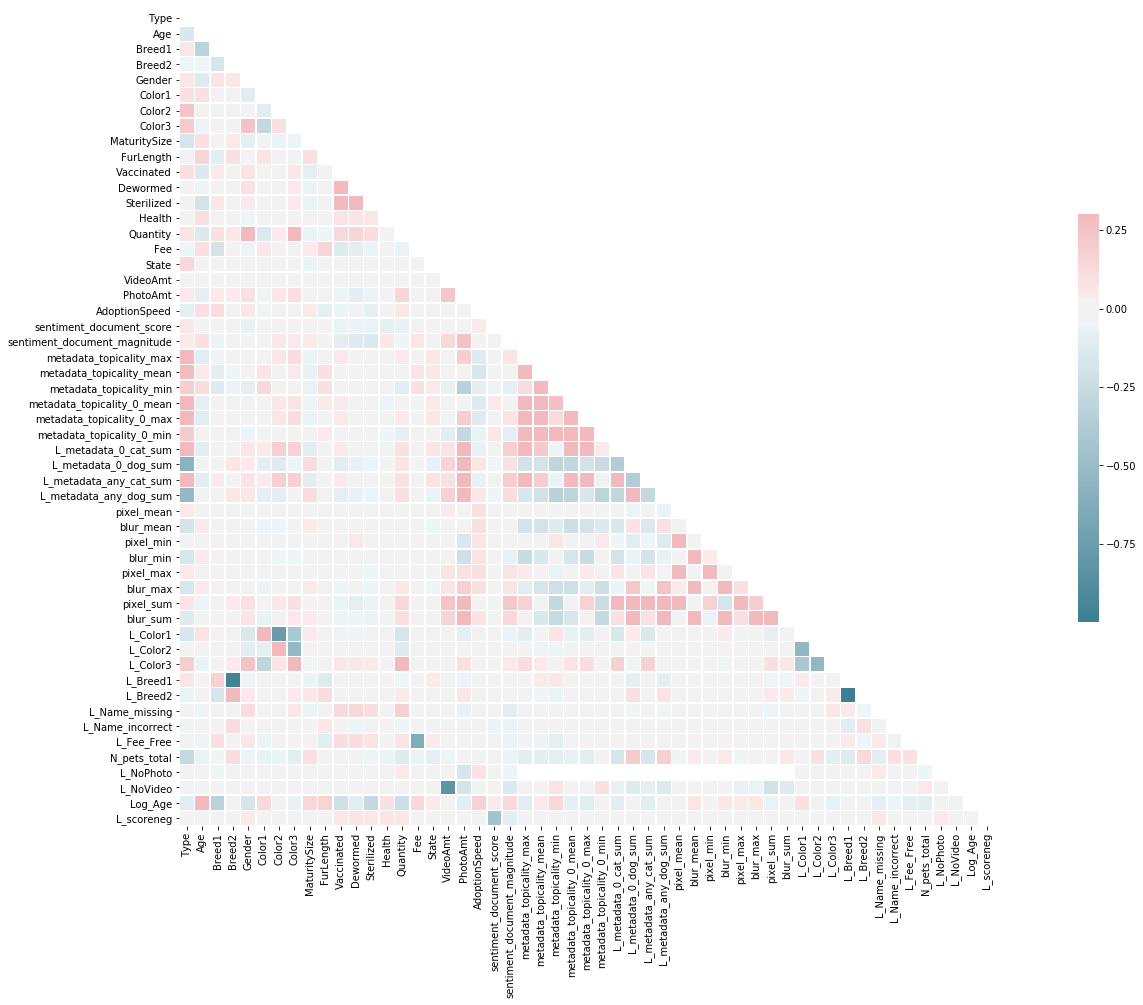

In [63]:
plot_correlation_matrix(train)